# Photometric Color correction in FGCM Model

- author : Sylvie Dagoret-Campagne
- affiliation : IJCLab/IN2P3/CNRS
- creation date : November 26th 2022
- last update : December 12th 2022

## Goal Study color bias wrt PWV

### Interpretable standard magnitude expression : option A : with zero point as unit observed counting rate
$$
\begin{eqnarray}
m_b^{std} & = &  -2.5 \log_{10}(C_b^{obs})+ 2.5 \log_{10}\left(\frac{\mathbb{I}_0^{std}(b)}{\mathbb{I}_0^{obs}}\right) + m_b^{obs}(ZPT)   \nonumber \\
 & & + 2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right)
\end{eqnarray}
$$

### Interpretable standard magnitude expression : option B : with zero point as constant

$$
\begin{eqnarray}
m_b^{std} & = &  -2.5 \log_{10}(C_b^{obs})+ 2.5 \log_{10}\left(\mathbb{I}_0^{std}(b)\right) + ZPT^{AB}   \nonumber \\
 & & + 2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right)
\end{eqnarray}
$$

### Standard Magnitude wit SED approximation

- we don't know the exact SED of some reference calibration stars (in LSST, for Auxtel)

$$
F_{\nu}(\lambda) = F_\nu(\lambda_b) \times \left(1 + f_\nu^\prime(\lambda_b)(\lambda-\lambda_b) + \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}(\lambda-\lambda_b)^2 + \cdots \right)
$$

$$
\begin{eqnarray}
m_b^{std} & = & -2.5 \log_{10}(C_b)  \nonumber \\
          &   &  + 2.5 \log_{10}(\mathbb{I}_0^{obs}(b)) + ZPT^{AB}  \nonumber \\
          &   &  + 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)
\end{eqnarray}
$$

### Error on Color Photometric Correction
$$
\begin{eqnarray}
\Delta m & = & \left| 2.5 \log_{10}\left(
\frac{\mathbb{I}_0^{std}(b)}
{\mathbb{I}_0^{obs}(b)}\right) +
2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right) \right. \nonumber \\
    & & \left. - 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)\right|
\end{eqnarray}  
$$

## Import

In [1]:
# Import some generally useful packages

import os
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
%matplotlib inline
import pandas as pd
from itertools import cycle, islice

In [2]:
# to enlarge the sizes
params = {'legend.fontsize': 'large',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}
plt.rcParams.update(params)


In [3]:
import matplotlib.offsetbox
props = dict(boxstyle='round',edgecolor="w",facecolor="w", alpha=0.5)

In [4]:
from scipy import interpolate

In [5]:
# Import the primary photometry classes from rubin_sim.photUtils

import rubin_sim.photUtils.Bandpass as Bandpass
import rubin_sim.photUtils.Sed as Sed
from rubin_sim.data import get_data_dir

In [6]:
pysynphot_root_path=os.environ['PYSYN_CDBS']
path_sed_calspec=os.path.join(pysynphot_root_path,'calspec')
# pysynphot
import pysynphot as S
S.refs.setref(area=1)
S.refs.getref()

{'graphtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/14l1632sm_tmg.fits',
 'comptable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/16n1832tm_tmc.fits',
 'thermtable': '/Users/dagoret/MacOSX/External/PySynPhotData/grp/hst/cdbs/mtab/tae17277m_tmt.fits',
 'area': 1,
 'waveset': 'Min: 500, Max: 26000, Num: 10000, Delta: None, Log: True'}

In [7]:
from libradtranpy import  libsimulateVisible

libradtranpath= /Users/dagoret/MacOSX/External/libRadtran2/


In [8]:
import warnings
warnings.filterwarnings("ignore")

## Configuration

### LSST Throughput

In [9]:
path_throughput="/sps/lsst/groups/auxtel/softs/github/desc/throughputs/baseline"
path_throughput=os.path.join(os.getenv("HOME"),"rubin_sim_data/throughputs/baseline") 

In [10]:
atm_std_filename = "atmos_std.dat"

In [105]:
filter_filenames = ["total_u.dat","total_g.dat","total_r.dat","total_i.dat","total_z.dat","total_y.dat" ]
filter_tagnames = ["u","g","r","i","z","y"]
Filter_tagnames = ["U","G","R","I","Z","Y"]
filtercolor_tagnames = ["u-g","g-r","r-i","i-z","z-y"]
Filtercolor_tagnames = ["U-G","G-R","R-I","I-Y","Z-Y"]
filter_color = ["b","g","r","orange","grey","k"]
NFILT=len(filter_filenames)

### Wavelength range and sampling

In [12]:
WLMIN=300.
WLMAX=1100.
WLBIN=1.
NWLBIN=int((WLMAX-WLMIN)/WLBIN)
WL=np.linspace(WLMIN,WLMAX,NWLBIN)

In [13]:
assert NWLBIN == len(WL)

### Backup observed air transparency

In [14]:
FLAG_BACKUP_ATMSIM = True
FLAG_ATMSIM_READFROMFILE = True
atmsim_backup_filename = "atmossim_obs_varypwv_21values.dat"

### Replace the standard atmosphere

In [15]:
FLAG_REPLACE_STANDARD_ATMOS = True
index_replace_atm=10

## Initialisation

In [16]:
df_std=pd.DataFrame()

In [17]:
df_std["wl"] = WL

### Standard atmosphere

In [18]:
fullfilename=os.path.join(path_throughput,atm_std_filename)

In [19]:
arr= np.loadtxt(fullfilename)

In [20]:
#f = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
f = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value=1)

In [21]:
atm_std=f(WL)

In [22]:
df_std["atm"] = atm_std

### Total filters

FILTERWL:

- index 0 : minimum wavelength of filter border
- index 1 : minimum wavelength of filter border
- index 2 : center wavelength of filter 
- index 3 : filter width

In [23]:
FILTERWL = np.zeros((NFILT,4))

# loop on filter
for index,filename in enumerate(filter_filenames):
    fullfilename=os.path.join(path_throughput,filename)
    arr= np.loadtxt(fullfilename)
    
    # interpolate  filter transmission
    ff = interpolate.interp1d(x=arr[:,0], y=arr[:,1],fill_value="extrapolate")
    
    # filter throughput including atm
    throughput1=ff(WL)
    # filter throughput without atm
    throughput2=throughput1/atm_std
    
    tag1="tot_"+filter_tagnames[index]
    tag2="inst_"+filter_tagnames[index]
    
    df_std[tag1]= throughput1
    df_std[tag2]= throughput2
    
    indexes=np.where(throughput2>0.05)[0]
    #left border of filter
    FILTERWL[index,0]=WL[indexes.min()] 
    # right border of the filter
    FILTERWL[index,1]=WL[indexes.max()] 
    # width of the filter
    FILTERWL[index,3]=WL[indexes.max()]-WL[indexes.min()]  
    #lambda_b
    lambdab=np.trapz(throughput2,WL)/np.trapz(throughput2/WL,WL)
    FILTERWL[index,2]=lambdab

In [24]:
FILTERWL

array([[ 324.03003755,  402.12765957,  363.59690349,   78.09762203],
       [ 392.11514393,  561.32665832,  473.54069923,  169.21151439],
       [ 542.3028786 ,  700.50062578,  619.49926767,  158.19774718],
       [ 681.47684606,  827.65957447,  752.01084117,  146.18272841],
       [ 808.63579474,  932.79098874,  868.488419  ,  124.15519399],
       [ 914.76846058, 1044.93116395,  969.10570859,  130.16270338]])

Text(0.5, 1.0, 'Instrument transmission')

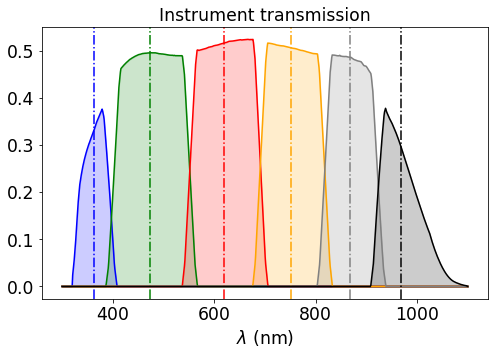

In [25]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
for index in range(NFILT):
    tag="inst_"+filter_tagnames[index]
    axs.plot(WL,df_std[tag].values,color=filter_color[index]) 
    axs.fill_between(WL,df_std[tag].values,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle="-.")
    #plt.axvline(FILTERWL[index,0],color=filter_color[index],linestyle=":")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument transmission")

Text(0.5, 1.0, 'Instrument and atmosphere transmission')

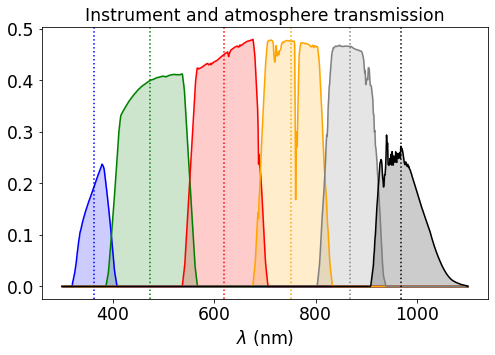

In [26]:
fig, axs = plt.subplots(1,1,figsize=(8,5))
for index in range(NFILT):
    tag="tot_"+filter_tagnames[index]
    axs.plot(WL,df_std[tag].values,color=filter_color[index]) 
    axs.fill_between(WL,df_std[tag].values,color=filter_color[index],alpha=0.2) 
    axs.axvline(FILTERWL[index,2],color=filter_color[index],linestyle=":")
axs.set_xlabel("$\\lambda$ (nm)")
axs.set_title("Instrument and atmosphere transmission")

In [27]:
df_std.head()

wl       atm  tot_u  inst_u  tot_g  inst_g  tot_r  inst_r  tot_i  \
0  300.000000  0.006410    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
1  301.001252  0.011915    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
2  302.002503  0.017428    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
3  303.003755  0.026622    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
4  304.005006  0.035820    0.0     0.0    0.0     0.0    0.0     0.0    0.0   

   inst_i  tot_z  inst_z  tot_y  inst_y  
0     0.0    0.0     0.0    0.0     0.0  
1     0.0    0.0     0.0    0.0     0.0  
2     0.0    0.0     0.0    0.0     0.0  
3     0.0    0.0     0.0    0.0     0.0  
4     0.0    0.0     0.0    0.0     0.0

## Functions

### Functions on passband Integrals 

$$
\mathbb{I}_0(b) \equiv \int_0^\infty S_b(\lambda) \frac{d\lambda}{\lambda}
$$

In [28]:
def fII0(wl,s):
    return np.trapz(s/wl,wl)

$$
\mathbb{I}_1(b) \equiv \int_0^\infty S_b(\lambda)(\lambda - \lambda_b) \frac{d\lambda}{\lambda}
$$

In [29]:
def fII1(wl,s,wlb):
    return np.trapz(s*(wl-wlb)/wl,wl)

$$
\mathbb{I}_2(b) \equiv \int_0^\infty S_b(\lambda)(\lambda-\lambda_b)^2 \frac{d\lambda}{\lambda}
$$

In [30]:
def fII2(wl,s,wlb):
    return np.trapz(s*(wl-wlb)**2/wl,wl)

$$
\mathbb{I}_{10}(b) \equiv \frac{\mathbb{I}_{1}(b)}{\mathbb{I}_{0}(b)}
$$

In [31]:
def fII10(wl,s,wlb):
    return fII1(wl,s,wlb)/fII0(wl,s)

$$
\mathbb{I}_{20}(b) \equiv \frac{\mathbb{I}_{2}(b)}{\mathbb{I}_{0}(b)}
$$

In [32]:
def fII20(wl,s,wlb):
    return fII2(wl,s,wlb)/fII0(wl,s)

### CalculateIIntegrals(df_S,wlb)

In [33]:
def CalculateIIntegrals(df_S,wlb):
    """
    
    input : 
     - df_S : dataframe containing transmission (atmosphere + instrument) 
     - lambda_b : center of passband
     
    output:
     - dataframe containing the integrals II0,II1,II2, II10, II20 for each filter (u,g,r,i,z,y)
     
    """
    II0 = np.zeros(NFILT)
    II1 = np.zeros(NFILT)
    II2 = np.zeros(NFILT)
    II10 = np.zeros(NFILT)
    II20 = np.zeros(NFILT)
    
    for index in range(NFILT):
        tag="tot_"+filter_tagnames[index]
        wl=df_S["wl"].values
        S=df_S[tag].values
        II0[index] = fII0(wl,S)
        II1[index] = fII1(wl,S,wlb[index])
        II2[index] = fII2(wl,S,wlb[index])
        II10[index] = fII10(wl,S,wlb[index])
        II20[index] = fII20(wl,S,wlb[index])
        
    df_II = pd.DataFrame()
    df_II["II0"]=II0
    df_II["II1"]=II1
    df_II["II2"]=II2
    df_II["II10"]=II10
    df_II["II20"]=II20    
    return df_II
    

## Calculate Integrals for Standard atmosphere

### Function SED integrals

- compute average over passband

$$
\frac{
\int_0^\infty q(\lambda) S_b^{tot} \frac{d\lambda}{\lambda}
}
{
\int_0^\infty  S_b^{tot} \frac{d\lambda}{\lambda}
}
$$

In [34]:
def ComputeAverage(the_wl,the_q,df_S):
    """
    
    input parameters:
      - the_wl : the wavelength array of the quantity over which one integrate
      - the_q : the quantity over which one integrate (ex the SED flux)
      - df_S : the passbands over which one integrates
      
    output:
      - all_qq_average : average over the_q in each passband (array)
      
    """
    
    
    # quantity that must be average
    func = interpolate.interp1d(x=the_wl, y=the_q,fill_value="extrapolate")
    qq_interp = func(WL)
    
    # Output for the average
    all_qq_average= np.zeros(NFILT)
    
    # loop on filters
    for index in range(NFILT):
        tag="tot_"+filter_tagnames[index]
        wl=df_S["wl"].values
        S = df_S[tag].values
        # weight for the average
        W = S/wl
        qq_average_inband = np.sum(W*qq_interp)/W.sum()
        all_qq_average[index] = qq_average_inband
    
    return all_qq_average
        

### Calculate Integrals for Standard atmosphere

In [35]:
df_IIstd = CalculateIIntegrals(df_std,FILTERWL[:,2])

In [36]:
df_IIstd 

II0       II1         II2      II10         II20
0  0.033338  0.079194   12.612354  2.375463   378.312338
1  0.121926  0.305935  230.105550  2.509184  1887.257382
2  0.100710  0.096977  167.700718  0.962933  1665.181331
3  0.077127  0.025279  109.332320  0.327765  1417.570239
4  0.053724 -0.024968   50.296178 -0.464738   936.189562
5  0.025932  0.089871   32.480106  3.465616  1252.500277

## Creation of observed transmission and set Precipitable Water Vapor variation effect

- create a dataframe df_obs containing all info related to observed atmosphere

### Simulation in libradtran

In [37]:
all_pwv = np.linspace(0,10.,21)
NPWV=len(all_pwv)
aer= 0.04
am=1.2
oz = 400

In [38]:
all_pwv_tags = []
for index,pwv in enumerate(all_pwv):
    pwv_tag = "pwv_"+str(int(pwv*10))
    all_pwv_tags.append(pwv_tag)
all_pwv_tags=np.array(all_pwv_tags)
all_pwv_tags

array(['pwv_0', 'pwv_5', 'pwv_10', 'pwv_15', 'pwv_20', 'pwv_25', 'pwv_30',
       'pwv_35', 'pwv_40', 'pwv_45', 'pwv_50', 'pwv_55', 'pwv_60',
       'pwv_65', 'pwv_70', 'pwv_75', 'pwv_80', 'pwv_85', 'pwv_90',
       'pwv_95', 'pwv_100'], dtype='<U7')

In [39]:
all_pwv

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

### Read the simulation of atmosphere if already backuped and fill df_obs

In [40]:
simulation_backupfile_found = False

if FLAG_ATMSIM_READFROMFILE:
    if os.path.exists(atmsim_backup_filename):
        arr=np.loadtxt(atmsim_backup_filename)
        
        nwlsim = arr.shape[0]
        ntranspsim = arr.shape[1]
        
        #check if format is convenient
        if nwlsim == NWLBIN and ntranspsim == NPWV:
            simulation_backupfile_found = True
            
            all_df_obs = []
            
            for index_pwv,pwv in enumerate(all_pwv):
                atm = arr[:,index_pwv]
                df_obs=pd.DataFrame()
                df_obs["wl"] = WL
                df_obs["atm"] = atm
                
                for findex in range(NFILT):
                    tag1="tot_"+filter_tagnames[findex]
                    tag2="inst_"+filter_tagnames[findex]
    
                    df_obs[tag1]= df_std[tag2].values*atm
                    df_obs[tag2]= df_std[tag2].values
    
                all_df_obs.append(df_obs)
        else:
            print(f"Not convenient format for file {atmsim_backup_filename}")
    else:
        print(f"file {atmsim_backup_filename} does not exist")

In [41]:
try:
    all_df_obs
except NameError:
    var_exists = False
else:
    if len(all_df_obs) >0:
        var_exists = True
    else:
        var_exists = True
var_exists

True

### If all_df_obs does not exist, then simulate 

In [42]:
if not var_exists:
    
    all_df_obs = []

    # if want to save this simulation
    if FLAG_BACKUP_ATMSIM:
        arrout = np.zeros((NWLBIN,NPWV))

    # loop on airmass
    for index,pwv in enumerate(all_pwv):
        path,thefile = libsimulateVisible.ProcessSimulationaer(am,pwv,oz,aer,0,prof_str='us',proc_str='sa',cloudext=0.0, FLAG_VERBOSE=False)
        data = np.loadtxt(os.path.join(path,thefile))
        f = interpolate.interp1d(x=data[:,0], y=data[:,1],fill_value="extrapolate")
        atm=f(WL)
    
        # backup in simulation in the array
        if FLAG_BACKUP_ATMSIM:
            arrout[:,index]=atm 
        
    
        df_obs=pd.DataFrame()
        df_obs["wl"] = WL
        df_obs["atm"] = atm
    
    
        for findex in range(NFILT):
            tag1="tot_"+filter_tagnames[findex]
            tag2="inst_"+filter_tagnames[findex]
    
            df_obs[tag1]= df_std[tag2].values*atm
            df_obs[tag2]= df_std[tag2].values
    
        all_df_obs.append(df_obs)
        
    if FLAG_BACKUP_ATMSIM:
        np.savetxt(atmsim_backup_filename, arrout)
    

### Plot observed atmospheric  transmission and comparison with standard atmosphere

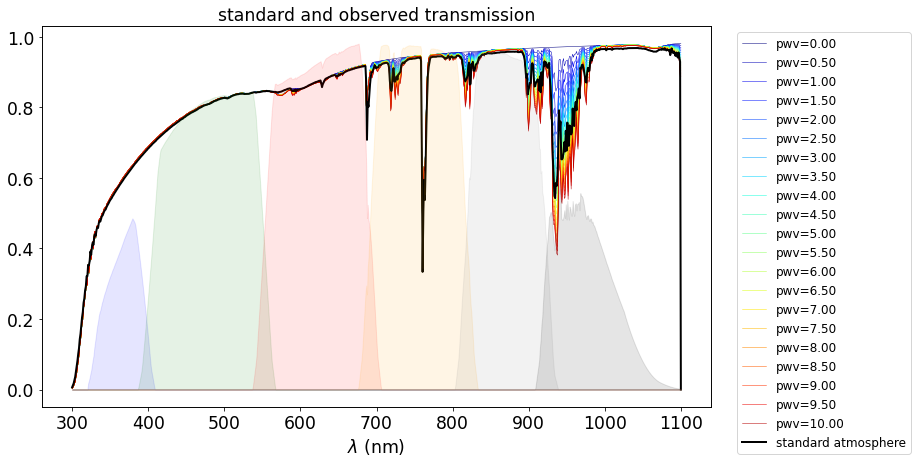

In [43]:
NOBS = len(all_df_obs)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig, axs = plt.subplots(1,1,figsize=(12,7))

for index,obs in enumerate(all_df_obs):
    atm = obs["atm"].values
    pwv = all_pwv[index]
    label = f"pwv={pwv:.2f}"
    
    axs.plot(WL,atm,color=all_colors[index],label=label,lw=0.5)

    
    
axs.plot(WL,df_std["atm"].values,color="k",lw=2,label="standard atmosphere")
axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")


ax2 = axs.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])



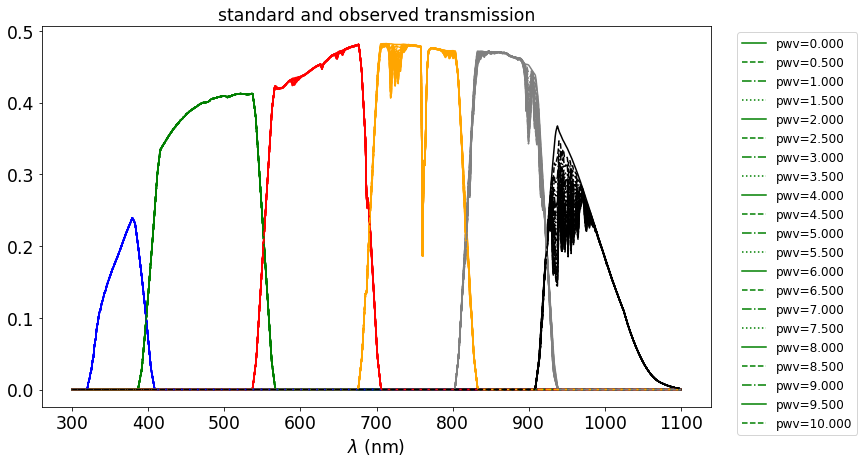

In [44]:
fig, axs = plt.subplots(1,1,figsize=(12,7))

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.','-','--','-.','-','--','-.']


for idx_pwv,the_obs in enumerate(all_df_obs):
    
    pwv = all_pwv[idx_pwv]
    label = f"pwv={pwv:.3f}"
    
    for findex in range(NFILT):
        tag1="tot_"+filter_tagnames[findex]
        tag2="inst_"+filter_tagnames[findex]

        if findex==1:
            axs.plot(the_obs["wl"],the_obs[tag1],color=filter_color[findex],linestyle=all_linestyles[idx_pwv],label=label )
        else:
            axs.plot(the_obs["wl"],the_obs[tag1],color=filter_color[findex],linestyle=all_linestyles[idx_pwv])

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("standard and observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0))  

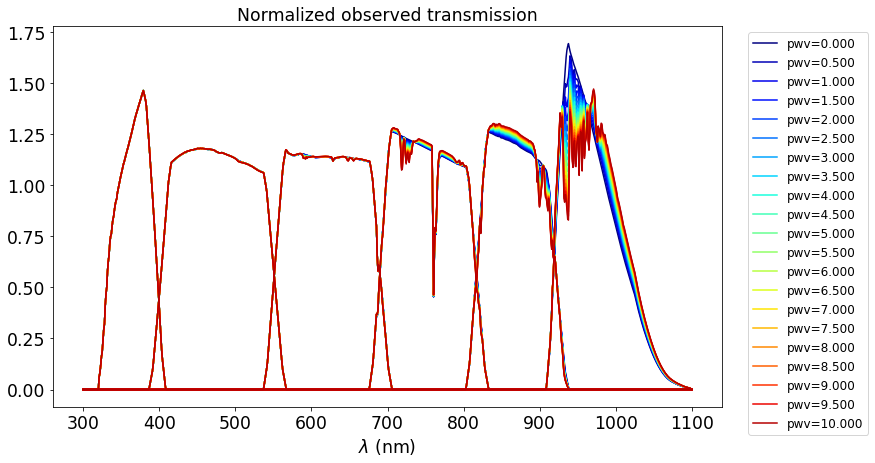

In [45]:
fig, axs = plt.subplots(1,1,figsize=(12,7))

all_linestyles = ['-','--','-.',':','-','--','-.',':','-','--','-.',':','-','--','-.',':']

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


for idx_pwv,the_obs in enumerate(all_df_obs):
    
   
    
    pwv = all_pwv[idx_pwv]
    label = f"pwv={pwv:.3f}"
    
    for findex in range(NFILT):
        tag1="tot_"+filter_tagnames[findex]
        tag2="inst_"+filter_tagnames[findex]

        the_II0=fII0(the_obs["wl"],the_obs[tag1])
        
        the_x=the_obs["wl"]
        the_dx=np.median(np.diff(the_x))
        the_y=the_obs[tag1]/the_II0/the_obs["wl"]*FILTERWL[findex,3]
        
        if findex==1:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-",label=label )
        else:
            axs.plot(the_x,the_y,color=all_colors[idx_pwv],linestyle="-")

axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Normalized observed transmission")
axs.legend(bbox_to_anchor=(1.03, 1.0))  

In [46]:
all_df_obs[0].head()

wl       atm  tot_u  inst_u  tot_g  inst_g  tot_r  inst_r  tot_i  \
0  300.000000  0.003082    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
1  301.001252  0.005647    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
2  302.002503  0.009337    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
3  303.003755  0.017061    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
4  304.005006  0.021317    0.0     0.0    0.0     0.0    0.0     0.0    0.0   

   inst_i  tot_z  inst_z  tot_y  inst_y  
0     0.0    0.0     0.0    0.0     0.0  
1     0.0    0.0     0.0    0.0     0.0  
2     0.0    0.0     0.0    0.0     0.0  
3     0.0    0.0     0.0    0.0     0.0  
4     0.0    0.0     0.0    0.0     0.0

### Replace standard atmosphere with known atmosphere

In [47]:
if FLAG_REPLACE_STANDARD_ATMOS:
    df_std=all_df_obs[index_replace_atm]
    df_IIstd = CalculateIIntegrals(df_std,FILTERWL[:,2])

In [48]:
df_std.head()

wl       atm  tot_u  inst_u  tot_g  inst_g  tot_r  inst_r  tot_i  \
0  300.000000  0.003082    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
1  301.001252  0.005647    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
2  302.002503  0.009338    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
3  303.003755  0.017062    0.0     0.0    0.0     0.0    0.0     0.0    0.0   
4  304.005006  0.021319    0.0     0.0    0.0     0.0    0.0     0.0    0.0   

   inst_i  tot_z  inst_z  tot_y  inst_y  
0     0.0    0.0     0.0    0.0     0.0  
1     0.0    0.0     0.0    0.0     0.0  
2     0.0    0.0     0.0    0.0     0.0  
3     0.0    0.0     0.0    0.0     0.0  
4     0.0    0.0     0.0    0.0     0.0

In [49]:
df_IIstd 

II0       II1         II2      II10         II20
0  0.033611  0.079827   12.693229  2.375001   377.645866
1  0.122330  0.297920  230.886856  2.435375  1887.409233
2  0.100765  0.113623  168.187941  1.127603  1669.108898
3  0.077961  0.024822  110.350060  0.318390  1415.459343
4  0.054154 -0.026793   50.706126 -0.494756   936.338975
5  0.026116  0.093622   32.709208  3.584867  1252.458616

# Integrals

## Calculate Integrals for observed atmosphere

In [50]:
all_df_IIobs = []
for idx,the_df_obs in enumerate(all_df_obs):
    the_df_IIobs = CalculateIIntegrals(the_df_obs,FILTERWL[:,2])
    all_df_IIobs.append(the_df_IIobs) 
    
    print(f"======== obs = {idx} =======")
    print(the_df_IIobs)

======== obs = 0 =======
        II0       II1         II2      II10         II20
0  0.033609  0.079828   12.692440  2.375170   377.646462
1  0.122342  0.298553  230.913636  2.440316  1887.444145
2  0.100919  0.115036  168.473523  1.139886  1669.394989
3  0.078955  0.021658  112.223056  0.274304  1421.362877
4  0.055784  0.006821   53.777626  0.122272   964.027417
5  0.030109  0.002158   35.529120  0.071669  1180.028666
======== obs = 1 =======
        II0       II1         II2      II10         II20
0  0.033609  0.079828   12.692494  2.375158   377.646416
1  0.122341  0.298493  230.910909  2.439853  1887.440847
2  0.100903  0.114889  168.444564  1.138606  1669.363520
3  0.078846  0.021965  112.016466  0.278582  1420.697494
4  0.055578  0.001790   53.364221  0.032201   960.175101
5  0.029379  0.020442   34.968257  0.695784  1190.230571
======== obs = 2 =======
        II0       II1         II2      II10         II20
0  0.033610  0.079828   12.692551  2.375146   377.646375
1  0.122340  

## Study of Integrals

In [51]:
df_IIstd 

II0       II1         II2      II10         II20
0  0.033611  0.079827   12.693229  2.375001   377.645866
1  0.122330  0.297920  230.886856  2.435375  1887.409233
2  0.100765  0.113623  168.187941  1.127603  1669.108898
3  0.077961  0.024822  110.350060  0.318390  1415.459343
4  0.054154 -0.026793   50.706126 -0.494756   936.338975
5  0.026116  0.093622   32.709208  3.584867  1252.458616

In [52]:
df_IIstd_2=df_IIstd.rename(index={0:'u',1:'g',2:'r',3:'i',4:'z',5:'y'})

In [53]:
df_IIstd_2=df_IIstd_2.transpose()

In [54]:
df_IIstd_2

u            g            r            i           z  \
II0     0.033611     0.122330     0.100765     0.077961    0.054154   
II1     0.079827     0.297920     0.113623     0.024822   -0.026793   
II2    12.693229   230.886856   168.187941   110.350060   50.706126   
II10    2.375001     2.435375     1.127603     0.318390   -0.494756   
II20  377.645866  1887.409233  1669.108898  1415.459343  936.338975   

                y  
II0      0.026116  
II1      0.093622  
II2     32.709208  
II10     3.584867  
II20  1252.458616

<AxesSubplot:title={'center':'Integrals values'}>

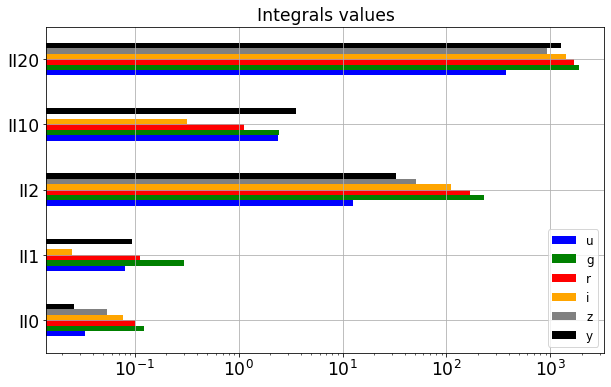

In [55]:
#my_colors = list(islice(cycle(['b', 'g', 'r', 'orange','grey','k']), None, len(df_IIstd_2)))
df_IIstd_2.plot.barh(log=True, figsize=(10,6),color=['b','g','r','orange','grey','k'],grid=True,title="Integrals values") 

## Calculate II differences

In [56]:
all_II_diff = []
for idx,pwv in enumerate(all_pwv):
    II_diff = all_df_IIobs[idx]-df_IIstd  
    all_II_diff.append(II_diff) 

In [57]:
all_II_div = []
for idx,pwv in enumerate(all_pwv):
    II_div = all_df_IIobs[idx]/df_IIstd  
    all_II_div.append(II_div) 

In [58]:
all_II_diff[15]

II0       II1       II2      II10       II20
0  0.000054 -0.000028  0.020375 -0.004660  -0.002339
1  0.000029 -0.002925  0.035811 -0.024473  -0.148605
2 -0.000164 -0.001454 -0.287452 -0.012616  -0.136730
3 -0.000530  0.001589 -0.940385  0.022698  -2.456661
4 -0.000671 -0.010318 -1.174482 -0.199126 -10.212019
5 -0.001102  0.022426 -0.769099  1.054467  24.434946

In [59]:
all_II_diff[7].iloc[5]["II0"]

0.0008018044389965957

## Plot integral difference between observed and standard atmosphere

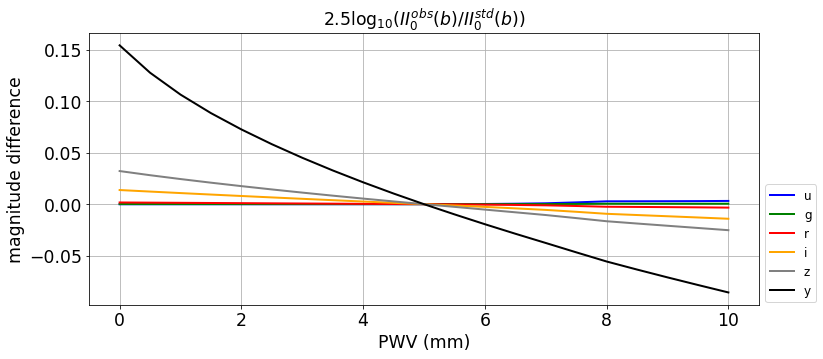

In [111]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_div_mag = np.zeros(NPWV)
    # loop on airmass to get the difference on II
    for idx,pwv in enumerate(all_pwv):
        the_div_mag[idx]= 2.5*np.log10(all_II_div[idx].iloc[ifilt]["II0"])
    ax.plot(all_pwv,the_div_mag,color=filter_color[ifilt],label=filter_tagnames[ifilt],lw=2)
ax.set_xlabel("PWV (mm)")
ax.set_ylabel("magnitude difference")
ax.set_title("$2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

- Magnitude corrections are of the order of 100 mmag, thus are huge. But what realu matters is the resolution on $\mathbb{I}_0^{obs}(b)$ 

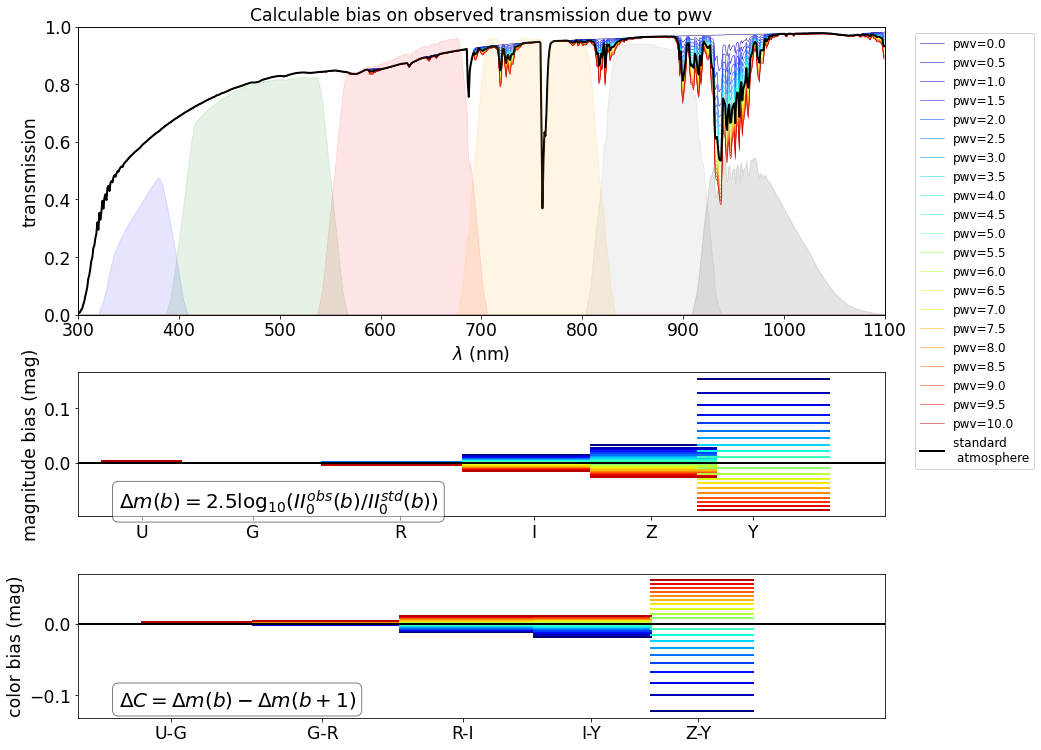

In [110]:
NOBS = len(all_df_obs)

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NOBS)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NOBS), alpha=1)


fig = plt.figure(figsize=(14,12))

gs = fig.add_gridspec(3, 1,  height_ratios=(3, 1.5, 1.5),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.05, hspace=0.3)

#top figure
axs = fig.add_subplot(gs[0, 0])

for index,obs in enumerate(all_df_obs):
    atm = obs["atm"].values
    pwv = all_pwv[index]
    label = f"pwv={pwv:.1f}"
    
    axs.plot(WL,atm,color=all_colors[index],label=label,lw=0.5)

    
    
axs.plot(WL,df_std["atm"].values,color="k",lw=2,label="standard \n atmosphere")
axs.legend(bbox_to_anchor=(1.03, 1.0))  
axs.set_xlabel("$\lambda$ (nm)")
axs.set_title("Calculable bias on observed transmission due to pwv")
axs.set_xlim(WLMIN,WLMAX)
axs.set_ylim(0,1)
axs.set_ylabel("transmission")


ax2 = axs.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,0,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])
ax2.set_ylim(0,0.5)

#middle figure
axs2 = fig.add_subplot(gs[1, 0])
for ifilt in range(NFILT): 
    the_div_mag = np.zeros(NPWV)
    # loop on airmass to get the difference on II
    for idx,z in enumerate(all_pwv):
        the_div_mag[idx]= 2.5*np.log10(all_II_div[idx].iloc[ifilt]["II0"])
        xx= [FILTERWL[ifilt,0],FILTERWL[ifilt,1]]
        yy= [the_div_mag[idx],the_div_mag[idx]]
        axs2.plot(xx,yy,color=all_colors[idx],lw=2)
axs2.set_xlim(WLMIN,WLMAX)
axs2.axhline(y=0,lw=2,color="k")
#axs2.set_xlabel("$\lambda$ (nm)")
axs2.set_xticks(FILTERWL[:,2])
axs2.set_xticklabels(Filter_tagnames, minor=False)
axs2.set_ylabel("magnitude bias (mag)")
#axs2.grid()
# these are matplotlib.patch.Patch properties
props = dict(boxstyle='round', facecolor='w', alpha=0.5)

textstr="$\Delta m(b) = 2.5 \log_{10} (II_0^{obs}(b)/II_0^{std}(b))$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs2.text(0.05, 0.2, textstr, transform=axs2.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)



# bottom figure
axs3 = fig.add_subplot(gs[2, 0])

for ifilt in range(NFILT-1): 
    the_div_mag = np.zeros(NPWV)
    # loop on airmass to get the difference on II
    for idx,z in enumerate(all_pwv):
        dcolor = 2.5*np.log10(all_II_div[idx].iloc[ifilt]["II0"])- 2.5*np.log10(all_II_div[idx].iloc[ifilt+1]["II0"])
        xx= [FILTERWL[ifilt,2],FILTERWL[ifilt+1,2]]
        yy= [dcolor,dcolor]
        axs3.plot(xx,yy,color=all_colors[idx],lw=2)
axs3.set_xlim(WLMIN,WLMAX)
axs3.axhline(y=0,lw=2,color="k")
#axs3.set_xlabel("$\lambda$ (nm)")

axs3.set_xticks(FILTERWL[1:,0])
axs3.set_xticklabels(Filtercolor_tagnames, minor=False)

axs3.set_ylabel("color bias (mag)")
#axs3.grid()
textstr="$\Delta C = \Delta m(b) - \Delta m(b+1)$"
#axs2.set_title(textstr)
# place a text box in upper left in axes coords
axs3.text(0.05, 0.2, textstr, transform=axs3.transAxes, fontsize=20,
        verticalalignment='top', bbox=props)


plt.tight_layout()    

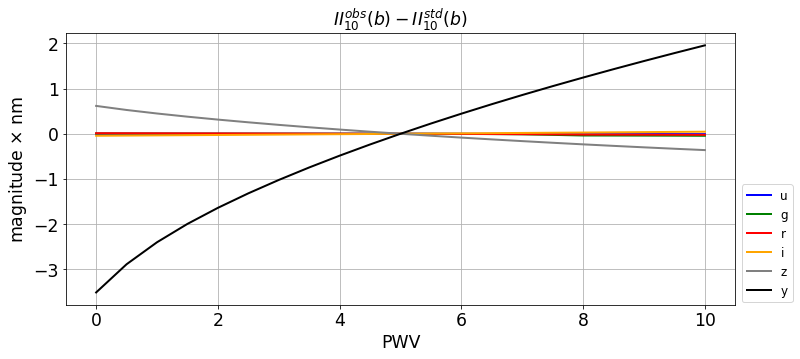

In [61]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_diff = np.zeros(NPWV)
    # loop on airmass to get the difference on II
    for idx,pwv in enumerate(all_pwv):
        the_diff[idx]=all_II_diff[idx].iloc[ifilt]["II10"]
    ax.plot(all_pwv,the_diff,color=filter_color[ifilt],label=filter_tagnames[ifilt],lw=2)
ax.set_xlabel("PWV")
ax.set_ylabel("magnitude $\\times$ nm")
ax.set_title("$II_{10}^{obs}(b)-II_{10}^{std}(b)$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

- $\mathbb{I}_{10}^{obs}(b)-\mathbb{I}_{10}^{std}(b)$ in magnitude x nm
- It must be multiplied by $f^{\prime}(\lambda_b)$ in $nm^{-1}$

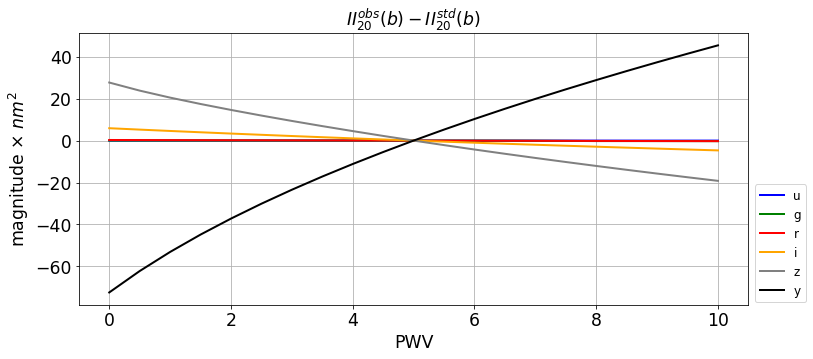

In [62]:
fig, ax = plt.subplots(1,1,figsize=(12,5))
# loop on filters
for ifilt in range(NFILT): 
    the_diff = np.zeros(NPWV)
    # loop on airmass to get the difference on II
    for idx,pwv in enumerate(all_pwv):
        the_diff[idx]=all_II_diff[idx].iloc[ifilt]["II20"]
    ax.plot(all_pwv,the_diff,color=filter_color[ifilt],label=filter_tagnames[ifilt],lw=2)
ax.set_xlabel("PWV")
ax.set_ylabel("magnitude $\\times \,\, nm^2$")
ax.set_title("$II_{20}^{obs}(b)-II_{20}^{std}(b)$")
ax.legend(loc=(1.01, 0.01))
ax.grid()

- $\mathbb{I}_{10}^{obs}(b)-\mathbb{I}_{10}^{std}(b)$ in magnitude x $nm^2$
- It must be multiplied by $f^{\prime\prime}(\lambda_b)$ in $nm^{-2}$

# SED

- Use SED sample from Lynne Jones
https://github.com/rhiannonlynne/photometry_sample

In [63]:
# this will contain attributes calculated for each SED
df_SED = pd.DataFrame(columns=["name","type"])

In [64]:
datadir = get_data_dir()
#sedDir = '/Users/lynnej/other_repos/photometry_sample'
sedDir = os.path.join(datadir,'photometry_sample')

sedtypes = ['galaxies', 'quasar', 'stars'] 
sedtypes_not_used = ['sn', 'photoZ_outliers', 'white_dwarf']
sedtypes = sedtypes + sedtypes_not_used

NSEDTYPES = len(sedtypes)

seds = {}
sedsfnu = {}
sedtypeslists = {}
count_sed =0

# loop on SED type
for idx,s in enumerate(sedtypes):
    sedtypelist = []
    # loop on object sed in SED type list
    filenames = os.listdir(os.path.join(sedDir, s))
    for f in filenames:
        name = f.replace('.dat', '').replace('.sed', '')
        
        if name == "m3.0Full":
            continue
            
        seds[name] = Sed()
        seds[name].readSED_flambda(os.path.join(sedDir, s, f))
        sedsfnu[name]= Sed()
    
        # save the name of the sed in the list
        sedtypelist.append(name) 
        df_SED.loc[count_sed] = [name,s]
        count_sed+=1
        
    # save the above list in a dictionary
    sedtypeslists[s] =  sedtypelist
        

In [65]:
df_SED=df_SED.set_index('name')
df_SED

type
name                               
Sa_template_norm           galaxies
Sdm_template_norm0         galaxies
Ell2_template_norm         galaxies
quasar                       quasar
km10_5250.fits_g45            stars
km10_4500.fits_g45            stars
km10_6000.fits_g45            stars
km10_7250.fits_g45            stars
km10_6500.fits_g45            stars
sn1a_10.0                        sn
sn1a_15.0                        sn
sn1a_20.0                        sn
xspec_173           photoZ_outliers
xspec_172           photoZ_outliers
xspec_90            photoZ_outliers
xspec_91            photoZ_outliers
xspec_176           photoZ_outliers
xspec_175           photoZ_outliers
wd_He_5500_80           white_dwarf
wd_H_5500_80            white_dwarf
wd_He_15000_80          white_dwarf
wd_H_50000_80           white_dwarf
wd_He_10000_80          white_dwarf
wd_H_100000_80          white_dwarf
wd_H_15000_80           white_dwarf

In [66]:
#list(seds.keys())

In [67]:
#sedtypeslists

In [68]:
NSED = len(list(seds.keys()))

# wavelength bin colors
jet = plt.get_cmap('jet')
cNorm = colors.Normalize(vmin=0, vmax=NSED)
scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
all_colors = scalarMap.to_rgba(np.arange(NSED), alpha=1)

In [69]:
# Redshift the quasar. Note repeat calls to this cell will stack, increasing the redshift multiple times.
z=1.5
seds['quasar'].redshiftSED(z)

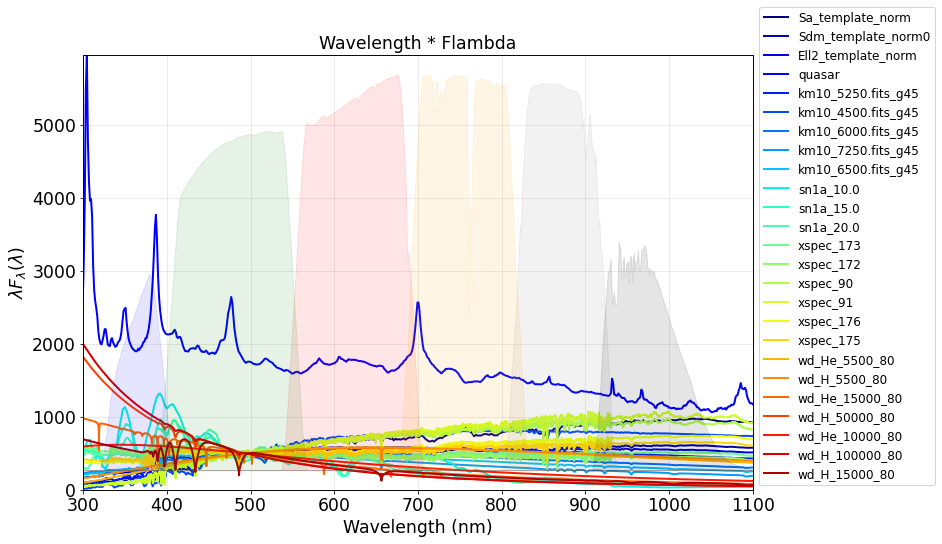

In [70]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,8))

sedmax=0
# loop on SED
for idx,n in enumerate(seds):
    ax.plot(seds[n].wavelen, seds[n].flambda * seds[n].wavelen, color=all_colors[idx],label=n,lw=2)
    
    fl = seds[n].flambda * seds[n].wavelen
    wav= seds[n].wavelen
    fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
    sedmax=max(sedmax,fl.max()) 
    
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.set_ylim(0, sedmax)
ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$\lambda F_\lambda(\lambda)$")
ax.set_title("Wavelength * Flambda")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

- m3 is a gmobular Cluster Messier 3 or NGC 5272

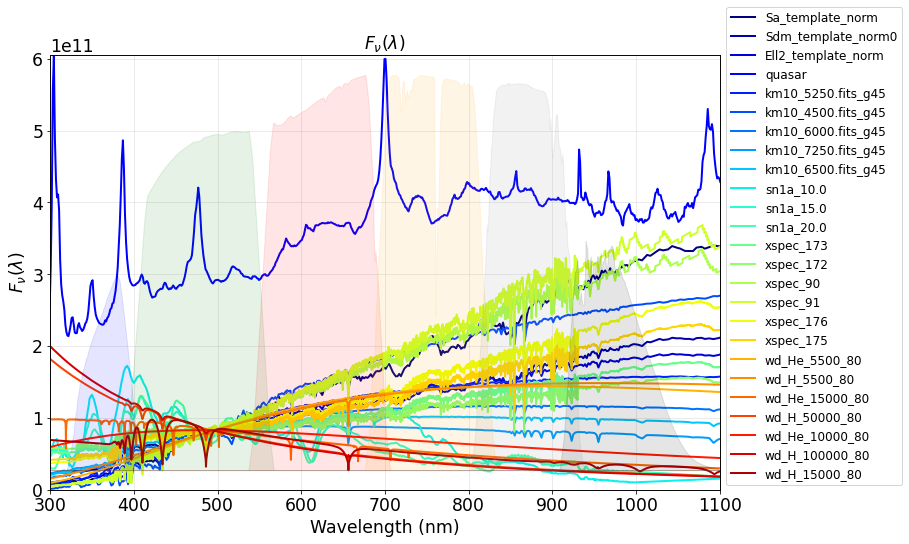

In [71]:
# Plot the seds
fig, ax = plt.subplots(1,1,figsize=(12,8))

# loop on SED
sedmax=0
for idx,name in enumerate(seds):
    wavel,fnu = seds[name].getSED_fnu()
    ax.plot(wavel, fnu, color=all_colors[idx],label=name,lw=2)
    
    
    fl = fnu
    wav= wavel
    fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
    sedmax=max(sedmax,fl.max()) 
    
ax.legend(loc=(1.01, 0.01))
ax.set_xlim(300, 1100)
ax.set_ylim(0, sedmax)

ax.grid(alpha=0.3)
ax.set_xlabel('Wavelength (nm)')
ax.set_ylabel("$F_\\nu (\lambda)$")
ax.set_title("$F_\\nu (\lambda)$")

ax2 = ax.twinx()
for ifilt in range(NFILT):
    tag="tot_"+filter_tagnames[ifilt]
    #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
    ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
    ax2.set_yticks([])

In [72]:
sedtypeslists["galaxies"]

['Sa_template_norm', 'Sdm_template_norm0', 'Ell2_template_norm']

In [73]:
wav

array([ 300. ,  300.1,  300.2, ..., 1199.8, 1199.9, 1200. ])

In [74]:
np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]

array([   0,    1,    2, ..., 7998, 7999, 8000])

Text(0.5, 1.0, 'SED $\\lambda F_\\lambda$')

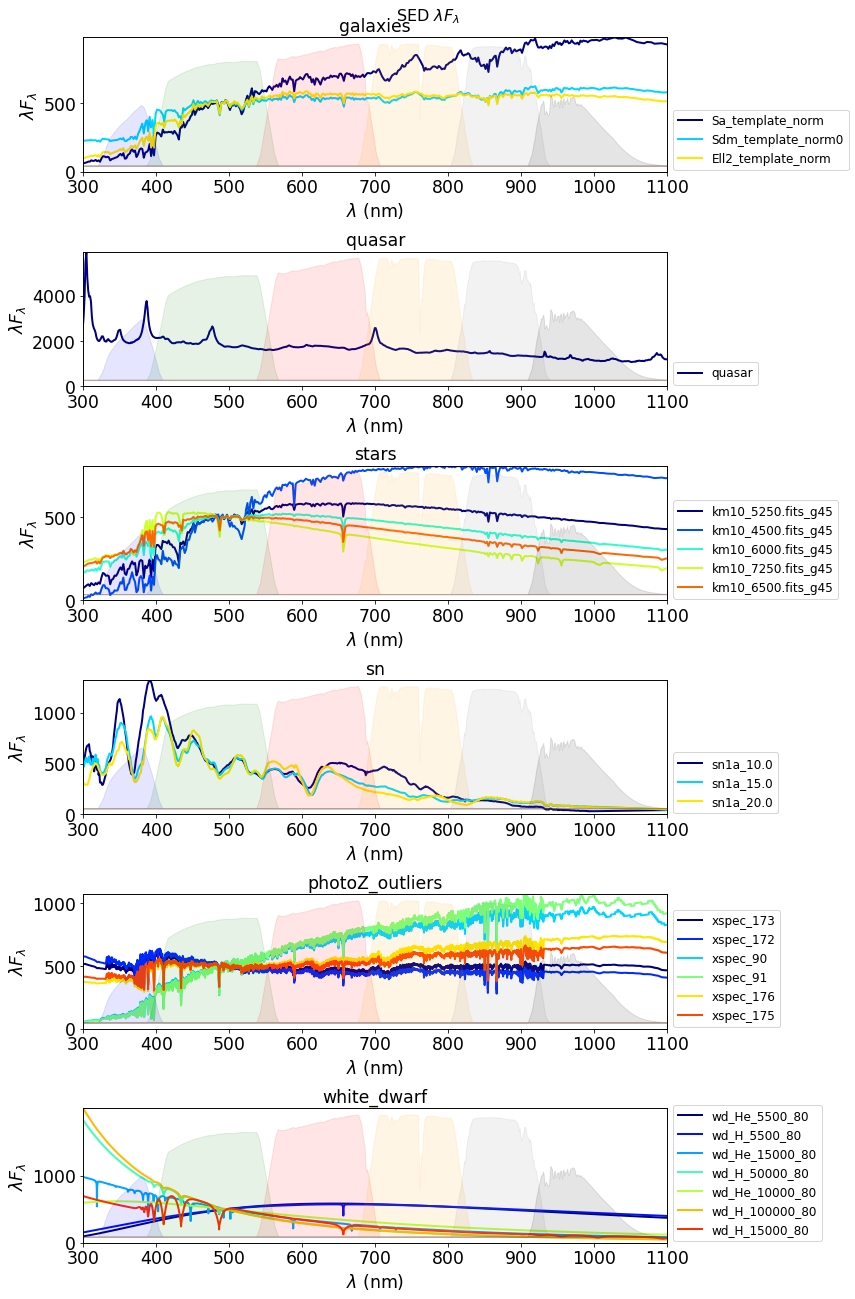

In [75]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))


# loop on all SED types
for idx,s in enumerate(sedtypes):
    
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    # loop on the SED of a given type
    sedmax=0
    for idx0,name in  enumerate(sednamelist):
        axs[idx].plot(seds[name].wavelen, seds[name].flambda * seds[name].wavelen, color=all_colors[idx0],label=name,lw=2)
        #compute SED max
        fl = seds[name].flambda * seds[name].wavelen
        wav= seds[name].wavelen
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
    
    axs[idx].set_ylim(0,sedmax)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$\lambda F_\lambda$")
    
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
plt.tight_layout()
plt.suptitle("SED $\\lambda F_\\lambda$",fontsize=16,y=1.0)

Text(0.5, 1.01, 'SED $F_\\nu$')

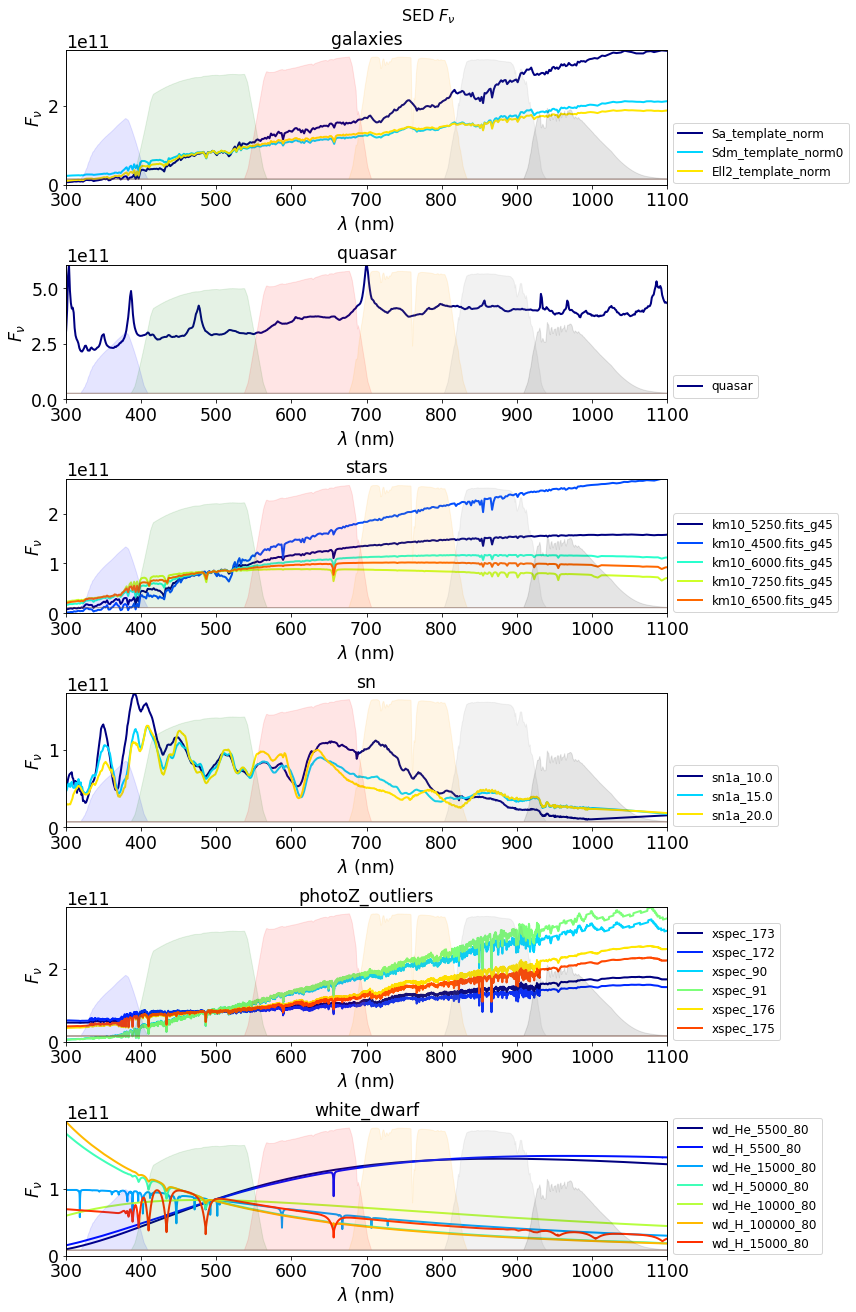

In [76]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

# loop on SED types
for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    sedmax=0
    # loop on objects in sedtypes
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        axs[idx].plot(wavel, fnu , color=all_colors[idx0],label=name,lw=2)
        #compute SED max
        fl = fnu
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        
    axs[idx].set_ylim(0,sedmax)
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$F_\\nu$")
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
plt.tight_layout()
plt.suptitle("SED $F_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'SED $f^\\prime_\\nu$')

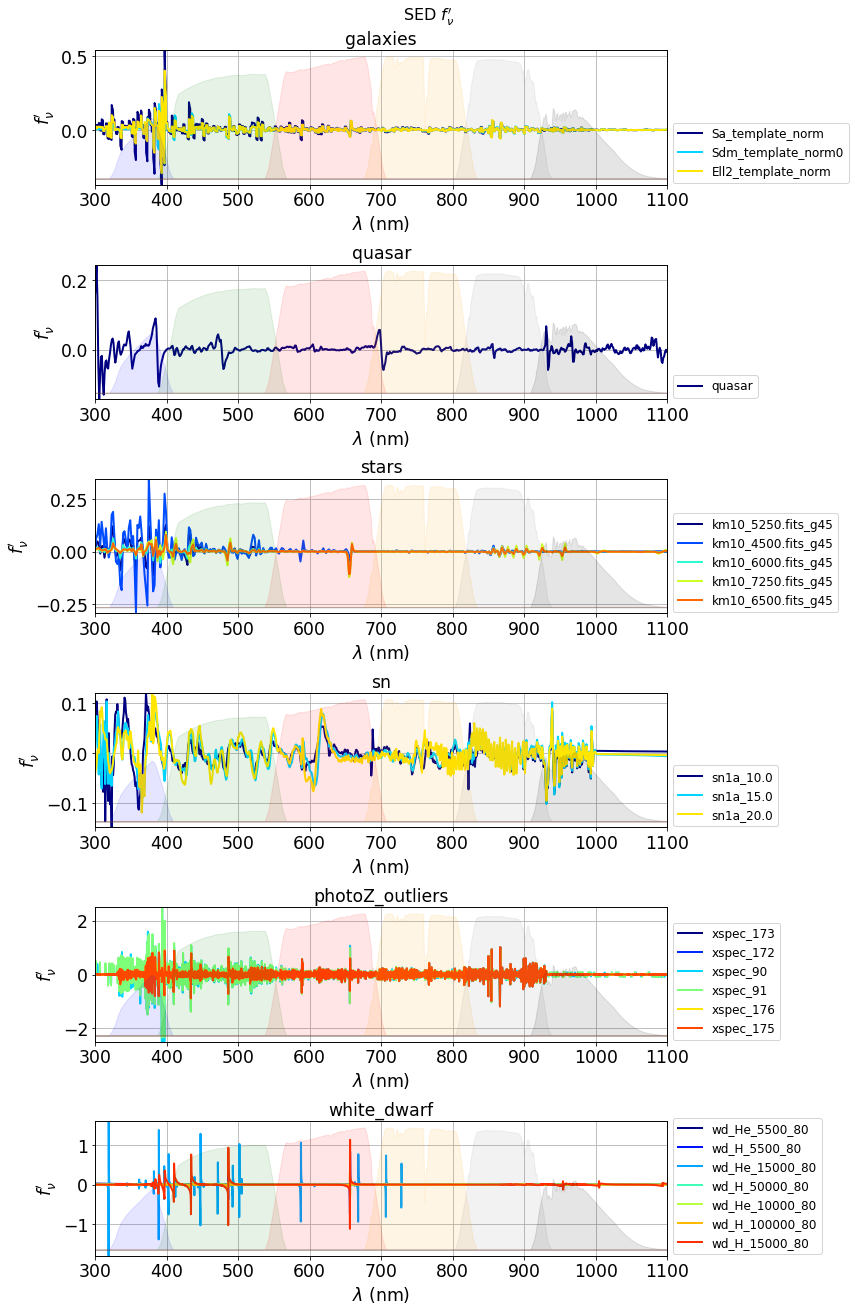

In [77]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))


# loop on SED types
for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    sedmin=0
    sedmax=0
    
    #loop on object in sedtype
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        x=wavel
        y = fnu
        fnup=np.gradient(y, x)
        fratio = fnup/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^\prime_\\nu$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("SED $f^\prime_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'SED $f^{\\prime\\prime}_\\nu$')

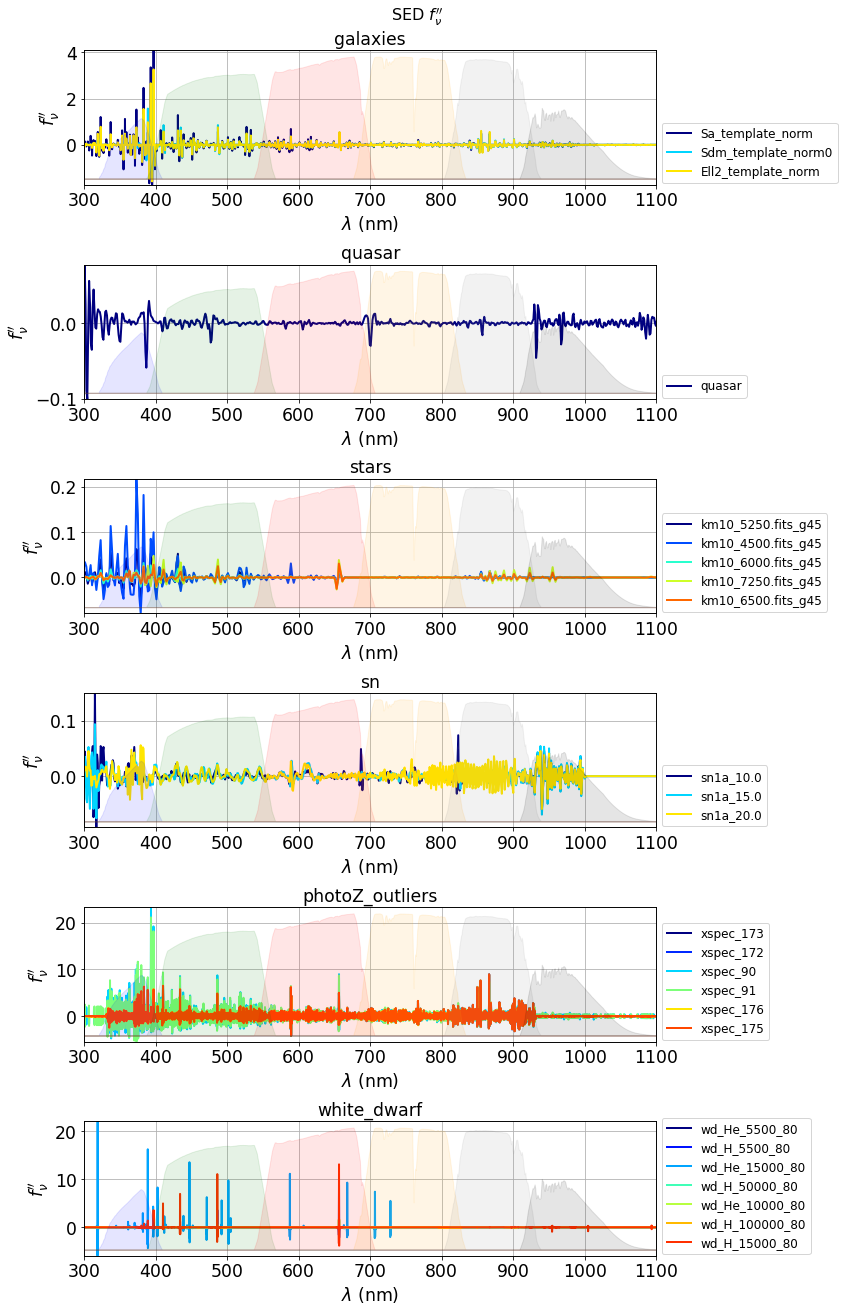

In [78]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    
    #loop on objects in sed type list
    sedmin=0
    sedmax=0
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        x=wavel
        y = fnu
        fnup=np.gradient(y, x)
        fnupp = np.gradient(fnup,x)
        fratio = fnupp/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^{\prime\prime}_\\nu$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("SED $f^{\prime\prime}_\\nu$",fontsize=16,y=1.01)

# Filtering the SED

In [79]:
def smooth_data_convolve_my_average(arr, span):
    re = np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

    # The "my_average" part: shrinks the averaging window on the side that 
    # reaches beyond the data, keeps the other side the same size as given 
    # by "span"
    re[0] = np.average(arr[:span])
    for i in range(1, span + 1):
        re[i] = np.average(arr[:i + span])
        re[-i] = np.average(arr[-i - span:])
    return re

def smooth_data_np_average(arr, span):  # my original, naive approach
    return [np.average(arr[val - span:val + span + 1]) for val in range(len(arr))]

def smooth_data_np_convolve(arr, span):
    return np.convolve(arr, np.ones(span * 2 + 1) / (span * 2 + 1), mode="same")

def smooth_data_np_cumsum_my_average(arr, span):
    cumsum_vec = np.cumsum(arr)
    moving_average = (cumsum_vec[2 * span:] - cumsum_vec[:-2 * span]) / (2 * span)

    # The "my_average" part again. Slightly different to before, because the
    # moving average from cumsum is shorter than the input and needs to be padded
    front, back = [np.average(arr[:span])], []
    for i in range(1, span):
        front.append(np.average(arr[:i + span]))
        back.insert(0, np.average(arr[-i - span:]))
    back.insert(0, np.average(arr[-2 * span:]))
    return np.concatenate((front, moving_average, back))

def smooth_data_lowess(arr, span):
    x = np.linspace(0, 1, len(arr))
    return sm.nonparametric.lowess(arr, x, frac=(5*span / len(arr)), return_sorted=False)

def smooth_data_kernel_regression(arr, span):
    # "span" smoothing parameter is ignored. If you know how to 
    # incorporate that with kernel regression, please comment below.
    kr = KernelReg(arr, np.linspace(0, 1, len(arr)), 'c')
    return kr.fit()[0]

def smooth_data_savgol_0(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 0)

def smooth_data_savgol_1(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 1)

def smooth_data_savgol_2(arr, span):  
    return savgol_filter(arr, span * 2 + 1, 2)

def smooth_data_fft(arr, span):  # the scaling of "span" is open to suggestions
    w = fftpack.rfft(arr)
    spectrum = w ** 2
    cutoff_idx = spectrum < (spectrum.max() * (1 - np.exp(-span / 2000)))
    w[cutoff_idx] = 0
    return fftpack.irfft(w)


In [80]:
# filtering width in nm
span=150

Text(0.5, 1.01, 'Filtered SED $F_\\nu$')

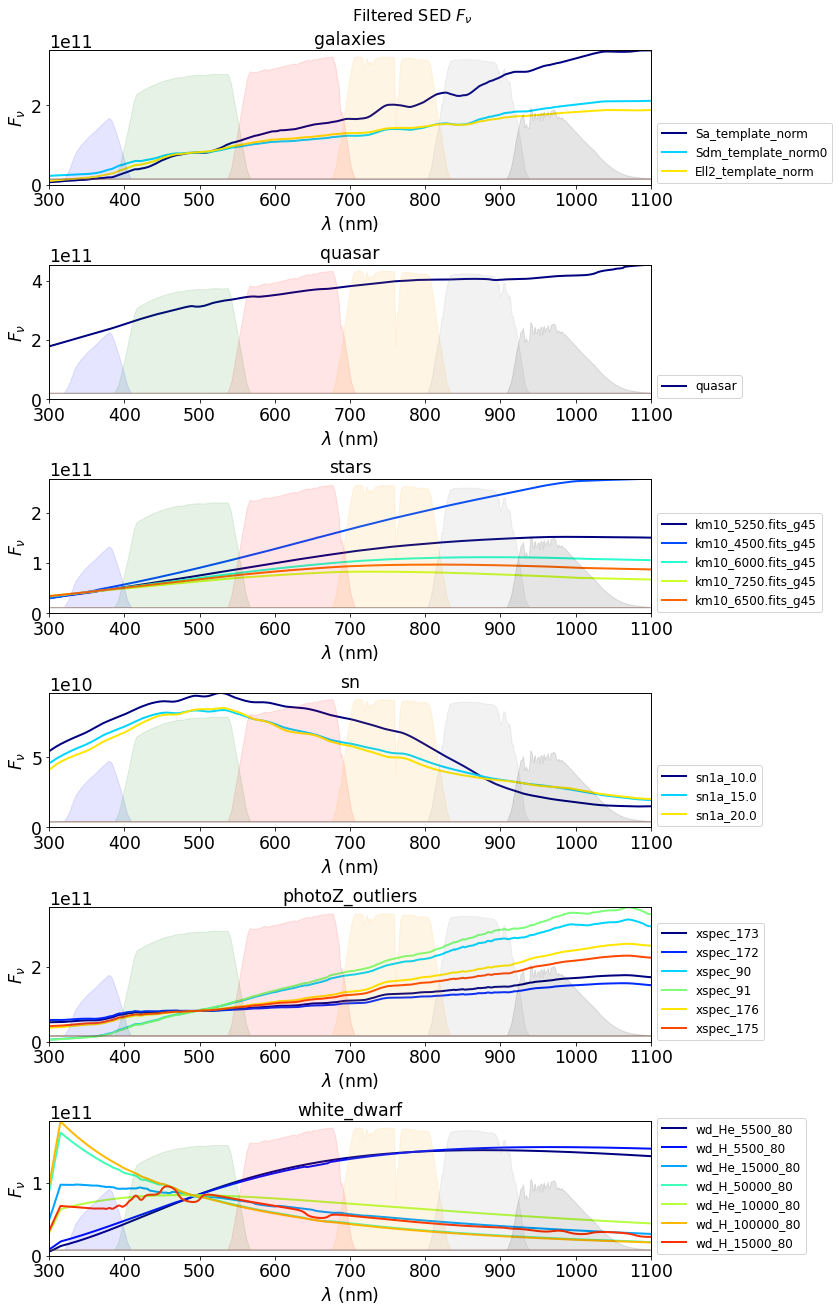

In [81]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    
    sedmin=0
    sedmax=0
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        
        axs[idx].plot(wavel, fnu_filtered , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fnu_filtered
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(0,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$F_\\nu$")
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
    
plt.tight_layout()
plt.suptitle("Filtered SED $F_\\nu$",fontsize=16,y=1.01)

Text(0.5, 1.01, 'Filtered SED $f^\\prime_\\nu$')

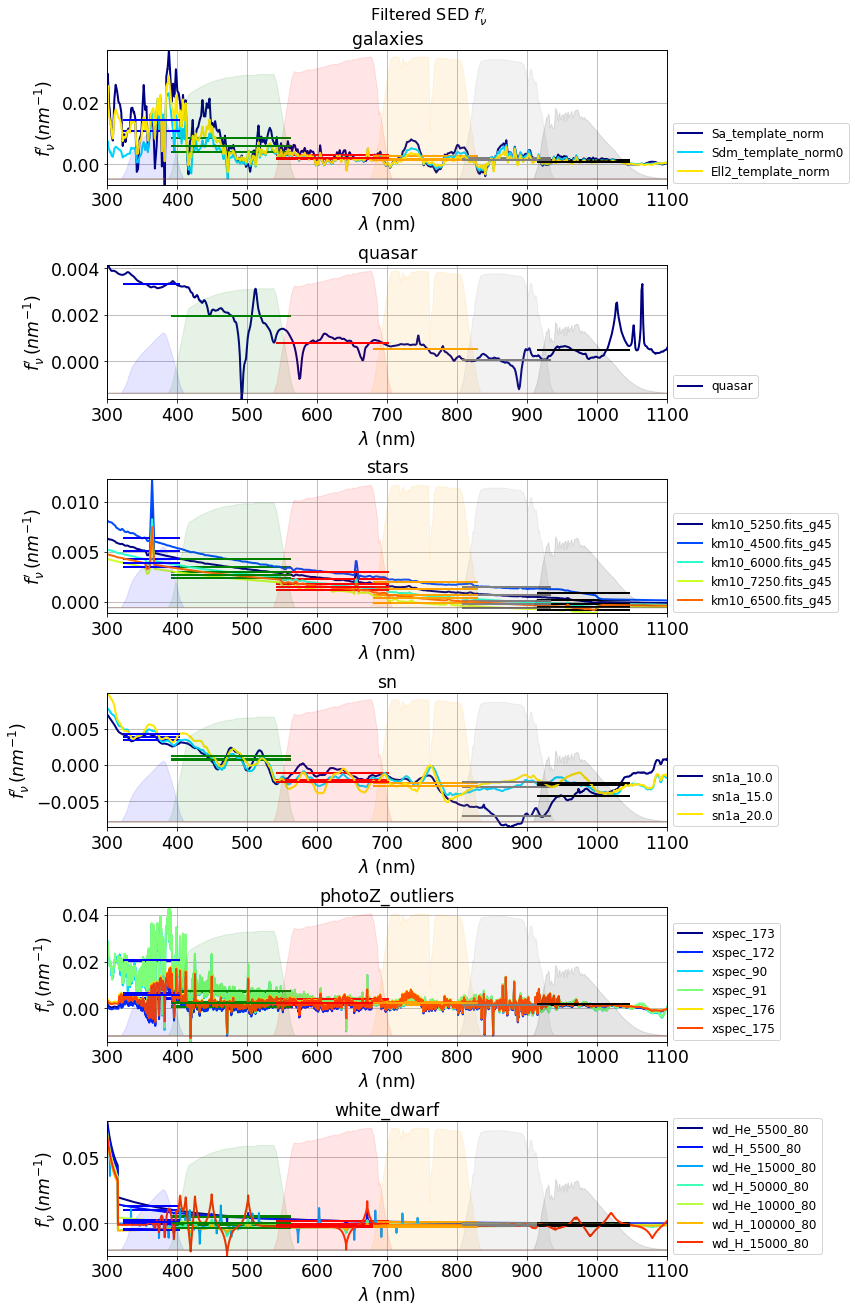

In [82]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

df_fp = pd.DataFrame(columns=["fp_u","fp_g","fp_r","fp_i","fp_z","fp_y"])

for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    sedmin=0
    sedmax=0
    # loop on object in sed type
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        x=wavel
        y = fnu_filtered
        fnup=np.gradient(y, x)
        fratio = fnup/fnu_filtered
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
        # average fp
        fp_filters = ComputeAverage(x,fratio,df_std)
        for ifilt in range(NFILT):
            axs[idx].plot([FILTERWL[ifilt,0],FILTERWL[ifilt,1]],[fp_filters[ifilt],fp_filters[ifilt]],color=filter_color[ifilt],lw=2)
        df_fp.loc[name] = fp_filters     
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^\prime_\\nu \, (nm^{-1})$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("Filtered SED $f^\prime_\\nu$",fontsize=16,y=1.01)

In [83]:
df_fp

fp_u      fp_g      fp_r      fp_i      fp_z      fp_y
Sa_template_norm    0.014306  0.008547  0.002844  0.002644  0.002086  0.001366
Sdm_template_norm0  0.010860  0.003987  0.001750  0.001750  0.001766  0.001111
Ell2_template_norm  0.014341  0.006005  0.001870  0.001269  0.001198  0.000734
quasar              0.003326  0.001947  0.000775  0.000516  0.000038  0.000485
km10_5250.fits_g45  0.005114  0.003498  0.002283  0.001227  0.000613  0.000155
km10_4500.fits_g45  0.006372  0.004272  0.002939  0.001960  0.001413  0.000855
km10_6000.fits_g45  0.004269  0.002959  0.001739  0.000666  0.000076 -0.000290
km10_7250.fits_g45  0.003431  0.002358  0.001123 -0.000107 -0.000625 -0.000822
km10_6500.fits_g45  0.003866  0.002683  0.001449  0.000341 -0.000215 -0.000518
sn1a_10.0           0.003489  0.000853 -0.001154 -0.002956 -0.007077 -0.004323
sn1a_15.0           0.003937  0.000748 -0.002065 -0.002479 -0.003092 -0.002779
sn1a_20.0           0.004263  0.001236 -0.002352 -0.002939 -0.002311 -0.002476
xspec_173           0.004546  0.001143  0.001475  0.001790  0.001065  0.001444
xspec_172           0.003926  0.000696  0.001169  0.001563  0.000895  0.001309
xspec_90            0.020093  0.007143  0.003538  0.002191  0.001743  0.001301
xspec_91            0.020620  0.007497  0.003793  0.002359  0.001881  0.001388
xspec_176           0.006403  0.002486  0.002389  0.002470  0.001573  0.001847
xspec_175           0.005785  0.002038  0.002085  0.002244  0.001405  0.001715
wd_He_5500_80       0.012813  0.005625  0.001918  0.000607  0.000040 -0.000245
wd_H_5500_80        0.009869  0.004864  0.001935  0.000783  0.000259 -0.000008
wd_He_15000_80     -0.000836 -0.001312 -0.001939 -0.001700 -0.001665 -0.001557
wd_H_50000_80      -0.004506 -0.003360 -0.002984 -0.002476 -0.002162 -0.001932
wd_He_10000_80      0.002238  0.000139 -0.000867 -0.001139 -0.001207 -0.001209
wd_H_100000_80     -0.004912 -0.003767 -0.003050 -0.002521 -0.002193 -0.001964
wd_H_15000_80       0.000538  0.000450 -0.002334 -0.001910 -0.001604 -0.001584

In [84]:
df_fp.describe()

fp_u       fp_g       fp_r       fp_i       fp_z       fp_y
count  25.000000  25.000000  25.000000  25.000000  25.000000  25.000000
mean    0.006166   0.002509   0.000733   0.000246  -0.000244  -0.000240
std     0.006448   0.003084   0.002134   0.001918   0.002087   0.001640
min    -0.004912  -0.003767  -0.003050  -0.002956  -0.007077  -0.004323
25%     0.003431   0.000748  -0.001154  -0.001700  -0.001604  -0.001557
50%     0.004269   0.002358   0.001475   0.000666   0.000076  -0.000008
75%     0.009869   0.004272   0.002085   0.001790   0.001405   0.001301
max     0.020620   0.008547   0.003793   0.002644   0.002086   0.001847

<AxesSubplot:title={'center':'$f_\\nu^{\\prime}$'}, ylabel='$f^{\\prime}_\\nu \\quad (nm^{-1})$'>

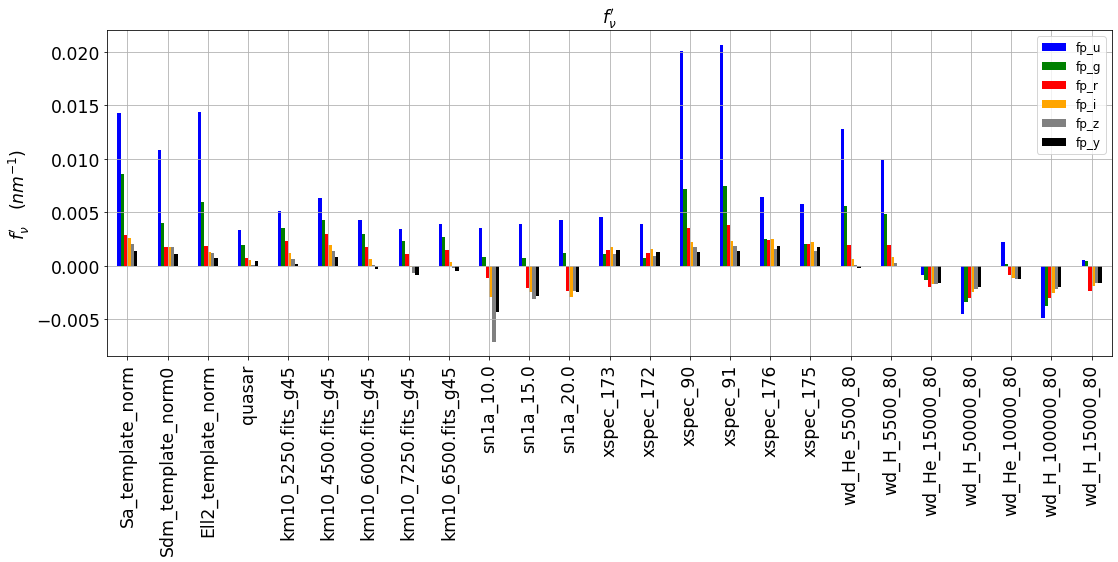

In [85]:
my_colors = list(islice(cycle(['b', 'g', 'r', 'orange','grey','k']), None, len(df_fp)))
df_fp.plot.bar(figsize=(18,6),ylabel="$f^{\prime}_\\nu \quad (nm^{-1})$",grid=True,color=my_colors,title="$f_\\nu^{\prime}$")

Text(0.5, 1.01, 'Filtered SED $f^{\\prime\\prime}_\\nu$')

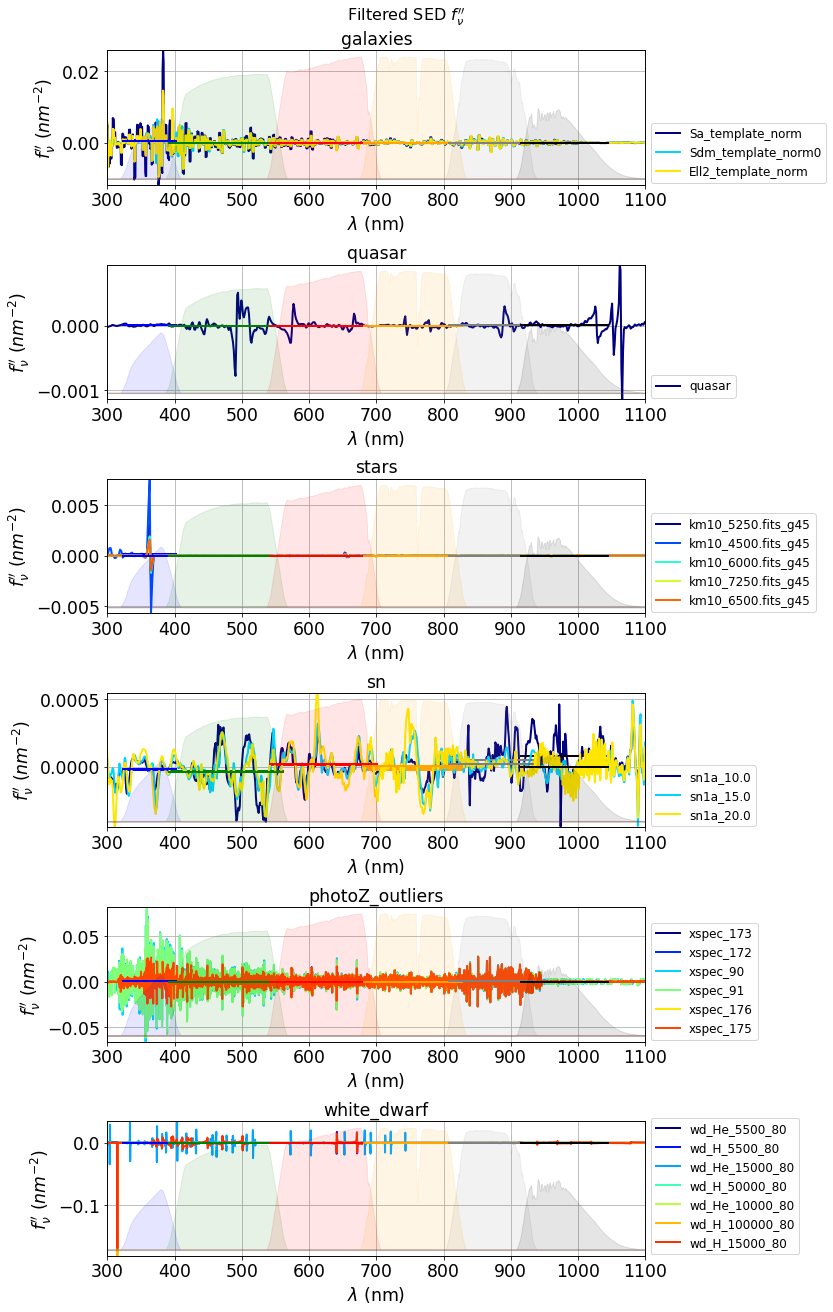

In [86]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(12,NSEDTYPES*3))

df_fpp = pd.DataFrame(columns=["fpp_u","fpp_g","fpp_r","fpp_i","fpp_z","fpp_y"])

# loop on sedtypes
for idx,s in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[s] 
    NSEDs = len(sednamelist)
    
    jet = plt.get_cmap('jet')
    cNorm = colors.Normalize(vmin=0, vmax=NSEDs)
    scalarMap = cmx.ScalarMappable(norm=cNorm, cmap=jet)
    all_colors = scalarMap.to_rgba(np.arange(NSEDs), alpha=1)
    
    #loop on object in sedypes
    sedmax=0
    sedmin=0
    
    for idx0,name in  enumerate(sednamelist):
        wavel,fnu = seds[name].getSED_fnu()
        fnu_filtered = smooth_data_np_convolve(fnu, span)
        x=wavel
        y = fnu_filtered
        fnup=np.gradient(y, x)
        fnupp = np.gradient(fnup,x)
        fratio = fnupp/fnu
        axs[idx].plot(wavel, fratio , color=all_colors[idx0],label=name,lw=2)
        
        #compute SED max
        fl = fratio
        wav= wavel
        fl = fl[np.where(np.logical_and(wav>=WLMIN,wav<=WLMAX))[0]]
        sedmax=max(sedmax,fl.max()) 
        sedmin=min(sedmin,fl.min()) 
        
        
        # average fpp
        fpp_filters = ComputeAverage(x,fratio,df_std)
        for ifilt in range(NFILT):
            axs[idx].plot([FILTERWL[ifilt,0],FILTERWL[ifilt,1]],[fpp_filters[ifilt],fpp_filters[ifilt]],color=filter_color[ifilt],lw=2)
        df_fpp.loc[name] = fpp_filters   
        
        
    axs[idx].legend(loc=(1.01, 0.01))
    axs[idx].set_title(s)
    axs[idx].set_xlim(WLMIN,WLMAX)
    axs[idx].set_ylim(sedmin,sedmax)
    axs[idx].set_xlabel('$\lambda$ (nm)')
    axs[idx].set_ylabel("$f^{\prime\prime}_\\nu \,\, (nm^{-2})$")
    axs[idx].grid()
    
    ax2 = axs[idx].twinx()
    for ifilt in range(NFILT):
        tag="tot_"+filter_tagnames[ifilt]
        #ax2.plot(WL,df_std[tag].values,color=filter_color[ifilt]) 
        ax2.fill_between(WL,df_std[tag].values,color=filter_color[ifilt],alpha=0.1) 
        ax2.set_yticks([])
    
plt.tight_layout()
plt.suptitle("Filtered SED $f^{\prime\prime}_\\nu$",fontsize=16,y=1.01)

In [87]:
df_fpp

fpp_u         fpp_g         fpp_r         fpp_i  \
Sa_template_norm    8.152319e-04  2.712724e-05 -1.143910e-05  2.372184e-05   
Sdm_template_norm0  3.805477e-04 -1.528918e-05 -8.900397e-06  1.264159e-05   
Ell2_template_norm  4.626907e-04 -2.036784e-05 -1.313077e-05  4.853201e-06   
quasar              4.489934e-06 -7.893961e-06 -3.638442e-06 -5.189250e-06   
km10_5250.fits_g45  3.103861e-05  2.237667e-06  6.625966e-07 -5.443811e-06   
km10_4500.fits_g45  1.616973e-04  8.044743e-06  4.696396e-06 -1.823881e-06   
km10_6000.fits_g45  9.310330e-06 -3.777185e-08 -2.468657e-06 -6.152499e-06   
km10_7250.fits_g45 -2.642845e-07 -2.071068e-06 -5.037383e-06 -6.780262e-06   
km10_6500.fits_g45  4.113703e-06 -1.010980e-06 -3.818901e-06 -6.300654e-06   
sn1a_10.0          -1.647509e-05 -3.508445e-05  1.021634e-05 -2.187350e-05   
sn1a_15.0          -2.244956e-05 -3.455344e-05  1.559225e-05 -9.042276e-06   
sn1a_20.0          -1.762033e-05 -3.813379e-05  2.279235e-05  7.740889e-06   
xspec_173           7.088315e-04 -1.673927e-05 -7.350559e-05 -2.181374e-05   
xspec_172           7.050234e-04 -2.094471e-05 -6.291783e-05 -2.770034e-05   
xspec_90            5.793602e-04  1.252921e-04  8.402046e-05  1.278444e-04   
xspec_91            5.777166e-04  7.045889e-05  6.076898e-05  1.012027e-04   
xspec_176           7.273197e-04 -8.029294e-06 -6.676743e-05 -2.177714e-05   
xspec_175           7.155671e-04 -3.693101e-06 -6.404587e-05 -1.727072e-05   
wd_He_5500_80       6.192767e-05 -7.900389e-06 -1.051453e-05 -6.101395e-06   
wd_H_5500_80        3.986617e-05  3.023709e-05 -5.842346e-06 -5.801844e-06   
wd_He_15000_80     -2.974859e-05  1.136528e-05 -4.278030e-05  9.191791e-05   
wd_H_50000_80       4.556472e-05  4.664840e-06  2.639153e-05  8.306924e-06   
wd_He_10000_80     -2.700909e-05 -1.165866e-05 -2.615685e-06  4.051544e-07   
wd_H_100000_80      4.233020e-05  1.106751e-05  2.790661e-05  8.424144e-06   
wd_H_15000_80       2.708018e-04 -1.286176e-05  1.317181e-05 -1.803499e-06   

                           fpp_z         fpp_y  
Sa_template_norm   -2.205115e-07 -2.904799e-06  
Sdm_template_norm0  7.314529e-07 -8.182138e-06  
Ell2_template_norm  1.966441e-08 -9.393045e-06  
quasar              1.064311e-06  6.009387e-06  
km10_5250.fits_g45 -3.494374e-06 -4.899143e-06  
km10_4500.fits_g45 -2.019307e-06 -8.887945e-06  
km10_6000.fits_g45 -3.769550e-06 -1.977281e-06  
km10_7250.fits_g45 -2.775437e-06  2.393961e-06  
km10_6500.fits_g45 -3.536874e-06 -2.647813e-07  
sn1a_10.0           5.031574e-05  7.920141e-05  
sn1a_15.0           2.007179e-05  3.501237e-08  
sn1a_20.0           1.969161e-05 -1.549959e-06  
xspec_173           2.379508e-04  4.823121e-05  
xspec_172           2.435825e-04  3.986700e-05  
xspec_90            6.889792e-05  1.914436e-04  
xspec_91            1.021690e-04  2.058271e-04  
xspec_176           2.425611e-04  3.975188e-05  
xspec_175           2.343428e-04  4.554722e-05  
wd_He_5500_80      -3.460312e-06 -2.023036e-06  
wd_H_5500_80       -3.623417e-06 -1.281734e-06  
wd_He_15000_80      3.917739e-06  3.243317e-06  
wd_H_50000_80       8.092355e-06  5.561508e-06  
wd_He_10000_80      1.248614e-06  1.633682e-06  
wd_H_100000_80      7.258260e-06  3.994584e-06  
wd_H_15000_80      -8.019770e-06  2.937736e-05

In [88]:
df_fpp.describe()

fpp_u      fpp_g      fpp_r      fpp_i      fpp_z      fpp_y
count  25.000000  25.000000  25.000000  25.000000  25.000000  25.000000
mean    0.000249   0.000002  -0.000004   0.000009   0.000048   0.000026
std     0.000309   0.000034   0.000037   0.000039   0.000089   0.000057
min    -0.000030  -0.000038  -0.000074  -0.000028  -0.000008  -0.000009
25%     0.000004  -0.000015  -0.000011  -0.000007  -0.000003  -0.000002
50%     0.000046  -0.000004  -0.000004  -0.000005   0.000001   0.000002
75%     0.000578   0.000008   0.000013   0.000008   0.000050   0.000040
max     0.000815   0.000125   0.000084   0.000128   0.000244   0.000206

<AxesSubplot:title={'center':'$f_\\nu^{\\prime\\prime}$'}, ylabel='$f^{\\prime\\prime}_\\nu \\quad (nm^{-2})$'>

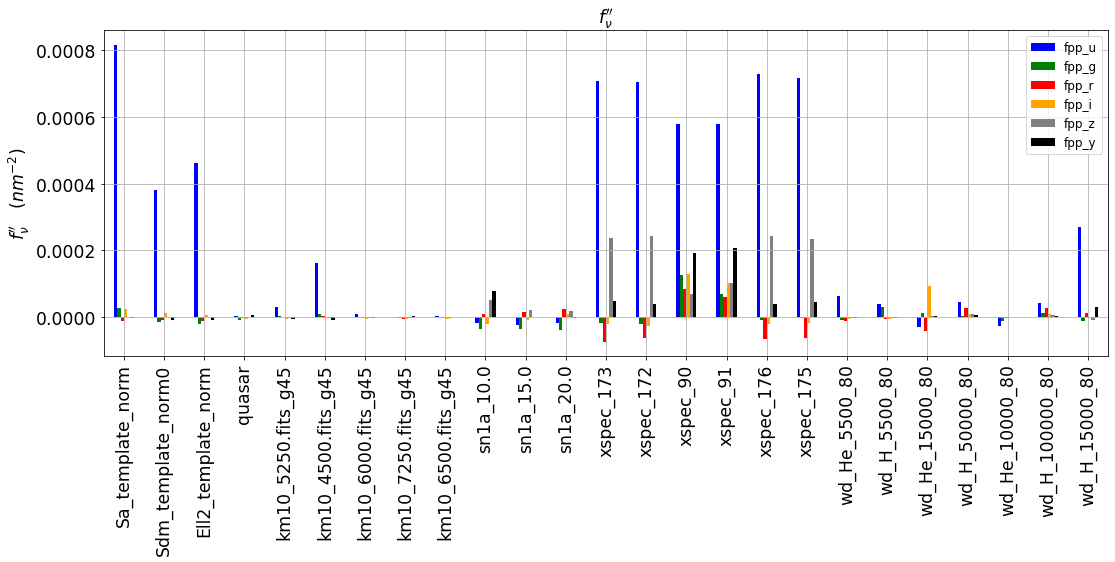

In [89]:
my_colors = list(islice(cycle(['b', 'g', 'r', 'orange','grey','k']), None, len(df_fpp)))
df_fpp.plot.bar(figsize=(18,6),ylabel="$f^{\prime\prime}_\\nu \quad (nm^{-2})$",grid=True,color=my_colors,title="$f_\\nu^{\prime\prime}$")

## Merge the three dataframe

In [90]:
df_SED_infos=pd.concat([df_SED,df_fp,df_fpp],axis=1)

In [91]:
df_SED_infos

type      fp_u      fp_g      fp_r      fp_i  \
Sa_template_norm           galaxies  0.014306  0.008547  0.002844  0.002644   
Sdm_template_norm0         galaxies  0.010860  0.003987  0.001750  0.001750   
Ell2_template_norm         galaxies  0.014341  0.006005  0.001870  0.001269   
quasar                       quasar  0.003326  0.001947  0.000775  0.000516   
km10_5250.fits_g45            stars  0.005114  0.003498  0.002283  0.001227   
km10_4500.fits_g45            stars  0.006372  0.004272  0.002939  0.001960   
km10_6000.fits_g45            stars  0.004269  0.002959  0.001739  0.000666   
km10_7250.fits_g45            stars  0.003431  0.002358  0.001123 -0.000107   
km10_6500.fits_g45            stars  0.003866  0.002683  0.001449  0.000341   
sn1a_10.0                        sn  0.003489  0.000853 -0.001154 -0.002956   
sn1a_15.0                        sn  0.003937  0.000748 -0.002065 -0.002479   
sn1a_20.0                        sn  0.004263  0.001236 -0.002352 -0.002939   
xspec_173           photoZ_outliers  0.004546  0.001143  0.001475  0.001790   
xspec_172           photoZ_outliers  0.003926  0.000696  0.001169  0.001563   
xspec_90            photoZ_outliers  0.020093  0.007143  0.003538  0.002191   
xspec_91            photoZ_outliers  0.020620  0.007497  0.003793  0.002359   
xspec_176           photoZ_outliers  0.006403  0.002486  0.002389  0.002470   
xspec_175           photoZ_outliers  0.005785  0.002038  0.002085  0.002244   
wd_He_5500_80           white_dwarf  0.012813  0.005625  0.001918  0.000607   
wd_H_5500_80            white_dwarf  0.009869  0.004864  0.001935  0.000783   
wd_He_15000_80          white_dwarf -0.000836 -0.001312 -0.001939 -0.001700   
wd_H_50000_80           white_dwarf -0.004506 -0.003360 -0.002984 -0.002476   
wd_He_10000_80          white_dwarf  0.002238  0.000139 -0.000867 -0.001139   
wd_H_100000_80          white_dwarf -0.004912 -0.003767 -0.003050 -0.002521   
wd_H_15000_80           white_dwarf  0.000538  0.000450 -0.002334 -0.001910   

                        fp_z      fp_y         fpp_u         fpp_g  \
Sa_template_norm    0.002086  0.001366  8.152319e-04  2.712724e-05   
Sdm_template_norm0  0.001766  0.001111  3.805477e-04 -1.528918e-05   
Ell2_template_norm  0.001198  0.000734  4.626907e-04 -2.036784e-05   
quasar              0.000038  0.000485  4.489934e-06 -7.893961e-06   
km10_5250.fits_g45  0.000613  0.000155  3.103861e-05  2.237667e-06   
km10_4500.fits_g45  0.001413  0.000855  1.616973e-04  8.044743e-06   
km10_6000.fits_g45  0.000076 -0.000290  9.310330e-06 -3.777185e-08   
km10_7250.fits_g45 -0.000625 -0.000822 -2.642845e-07 -2.071068e-06   
km10_6500.fits_g45 -0.000215 -0.000518  4.113703e-06 -1.010980e-06   
sn1a_10.0          -0.007077 -0.004323 -1.647509e-05 -3.508445e-05   
sn1a_15.0          -0.003092 -0.002779 -2.244956e-05 -3.455344e-05   
sn1a_20.0          -0.002311 -0.002476 -1.762033e-05 -3.813379e-05   
xspec_173           0.001065  0.001444  7.088315e-04 -1.673927e-05   
xspec_172           0.000895  0.001309  7.050234e-04 -2.094471e-05   
xspec_90            0.001743  0.001301  5.793602e-04  1.252921e-04   
xspec_91            0.001881  0.001388  5.777166e-04  7.045889e-05   
xspec_176           0.001573  0.001847  7.273197e-04 -8.029294e-06   
xspec_175           0.001405  0.001715  7.155671e-04 -3.693101e-06   
wd_He_5500_80       0.000040 -0.000245  6.192767e-05 -7.900389e-06   
wd_H_5500_80        0.000259 -0.000008  3.986617e-05  3.023709e-05   
wd_He_15000_80     -0.001665 -0.001557 -2.974859e-05  1.136528e-05   
wd_H_50000_80      -0.002162 -0.001932  4.556472e-05  4.664840e-06   
wd_He_10000_80     -0.001207 -0.001209 -2.700909e-05 -1.165866e-05   
wd_H_100000_80     -0.002193 -0.001964  4.233020e-05  1.106751e-05   
wd_H_15000_80      -0.001604 -0.001584  2.708018e-04 -1.286176e-05   

                           fpp_r         fpp_i         fpp_z         fpp_y  
Sa_template_norm   -1.143910e-05  2.372184e-05 -2.205115e-07 -2.904799e-06  
S

# Photometric correction - Color effect vs airmass

In [92]:
all_II_diff[1]

II0           II1       II2      II10       II20
0 -0.000002  5.277411e-07 -0.000736  0.000157   0.000550
1  0.000011  5.738371e-04  0.024053  0.004478   0.031613
2  0.000138  1.266204e-03  0.256622  0.011003   0.254622
3  0.000886 -2.856837e-03  1.666406 -0.039809   5.238150
4  0.001424  2.858251e-02  2.658094  0.526958  23.836126
5  0.003263 -7.318068e-02  2.259050 -2.889083 -62.228045

## Photometric corretion with $f_\nu^\prime$ only

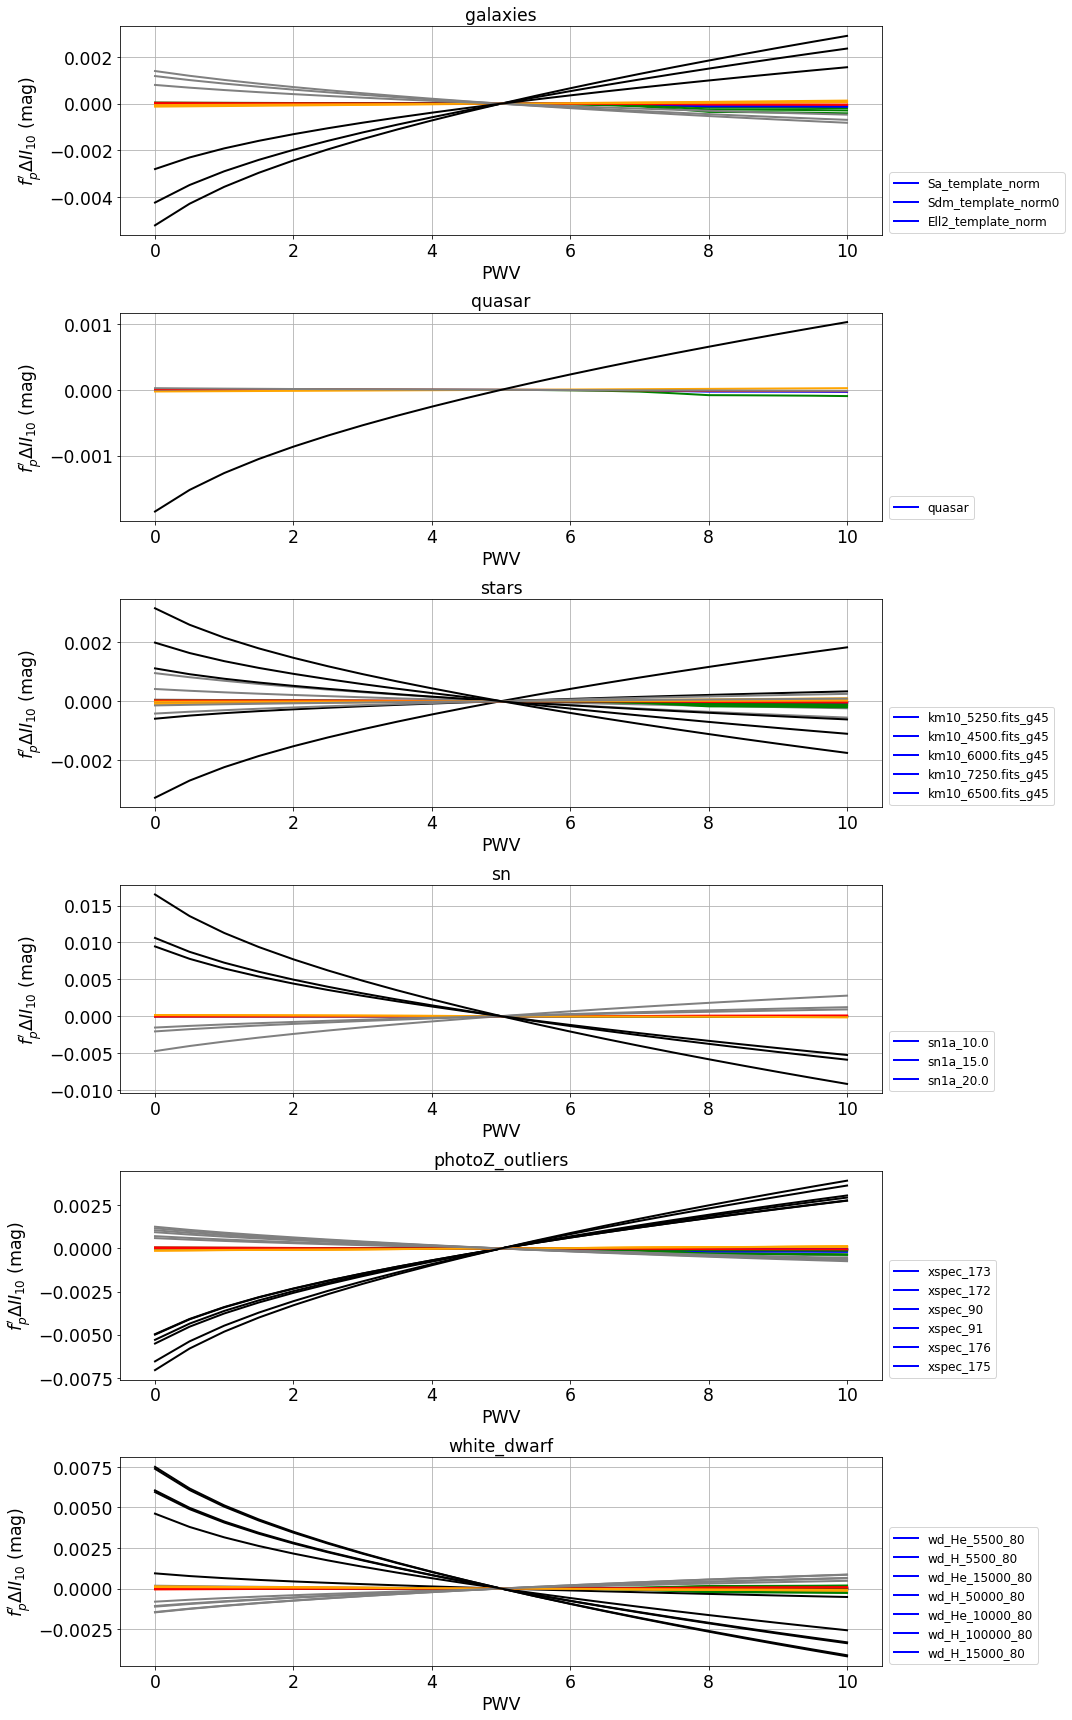

In [93]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(15,NSEDTYPES*4))

old_type = None
idx_sed = -1

# loop on SED
for index_name, row in df_SED_infos.iterrows():
    the_type = row["type"]
    if the_type != old_type:
        idx_sed+=1
        old_type = the_type
        #print(f"new type {the_type} !!!")
        
    #print("\t",index_name,row["type"])
    for ifilt in range(NFILT):
        coeff_tag = "fp_"+ filter_tagnames[ifilt]
        coeff_value = df_SED_infos.loc[index_name][coeff_tag]
        DeltaMag = np.zeros(NPWV)
        for idx_pwv,pwv in enumerate(all_pwv):
            Delta_II10 = all_II_diff[idx_pwv].loc[ifilt]["II10"]
            DeltaMag[idx_pwv] =  1.087*(Delta_II10*coeff_value)
        if ifilt==0:
            axs[idx_sed].plot(all_pwv,DeltaMag,color=filter_color[ifilt],label=index_name,lw=2) 
        else:
            axs[idx_sed].plot(all_pwv,DeltaMag,color=filter_color[ifilt],lw=2)
        
    axs[idx_sed].legend(loc=(1.01, 0.01))
    axs[idx_sed].set_xlabel("PWV")
    axs[idx_sed].set_ylabel("$f^\prime_p \Delta II_{10}$ (mag)")
    axs[idx_sed].set_title(the_type)
    axs[idx_sed].grid()
            
plt.tight_layout()        
        

## Photometric correction with $f_\nu^\prime$ and $f_\nu^{\prime\prime}$ 

### Build the columns tags

In [94]:
from collections import OrderedDict

In [95]:
all_columns = OrderedDict()
all_columns["name"] = 'str'
all_columns["type"] = 'str'
all_columns["filter"] = 'str'
for tag in all_pwv_tags:
    all_columns[f"c_1_{tag}"] = 'float'
    all_columns[f"c_2_{tag}"] = 'float'
    all_columns[f"c_3_{tag}"] = 'float'
    all_columns[f"c_t_{tag}"] = 'float'
print(all_columns)
print(len(all_columns))

OrderedDict([('name', 'str'), ('type', 'str'), ('filter', 'str'), ('c_1_pwv_0', 'float'), ('c_2_pwv_0', 'float'), ('c_3_pwv_0', 'float'), ('c_t_pwv_0', 'float'), ('c_1_pwv_5', 'float'), ('c_2_pwv_5', 'float'), ('c_3_pwv_5', 'float'), ('c_t_pwv_5', 'float'), ('c_1_pwv_10', 'float'), ('c_2_pwv_10', 'float'), ('c_3_pwv_10', 'float'), ('c_t_pwv_10', 'float'), ('c_1_pwv_15', 'float'), ('c_2_pwv_15', 'float'), ('c_3_pwv_15', 'float'), ('c_t_pwv_15', 'float'), ('c_1_pwv_20', 'float'), ('c_2_pwv_20', 'float'), ('c_3_pwv_20', 'float'), ('c_t_pwv_20', 'float'), ('c_1_pwv_25', 'float'), ('c_2_pwv_25', 'float'), ('c_3_pwv_25', 'float'), ('c_t_pwv_25', 'float'), ('c_1_pwv_30', 'float'), ('c_2_pwv_30', 'float'), ('c_3_pwv_30', 'float'), ('c_t_pwv_30', 'float'), ('c_1_pwv_35', 'float'), ('c_2_pwv_35', 'float'), ('c_3_pwv_35', 'float'), ('c_t_pwv_35', 'float'), ('c_1_pwv_40', 'float'), ('c_2_pwv_40', 'float'), ('c_3_pwv_40', 'float'), ('c_t_pwv_40', 'float'), ('c_1_pwv_45', 'float'), ('c_2_pwv_45', 'f

### Book the dataframe

In [96]:
all_II_diff[15]

II0       II1       II2      II10       II20
0  0.000054 -0.000028  0.020375 -0.004660  -0.002339
1  0.000029 -0.002925  0.035811 -0.024473  -0.148605
2 -0.000164 -0.001454 -0.287452 -0.012616  -0.136730
3 -0.000530  0.001589 -0.940385  0.022698  -2.456661
4 -0.000671 -0.010318 -1.174482 -0.199126 -10.212019
5 -0.001102  0.022426 -0.769099  1.054467  24.434946

In [97]:
df_pc_col_pwv = pd.DataFrame(columns=all_columns)

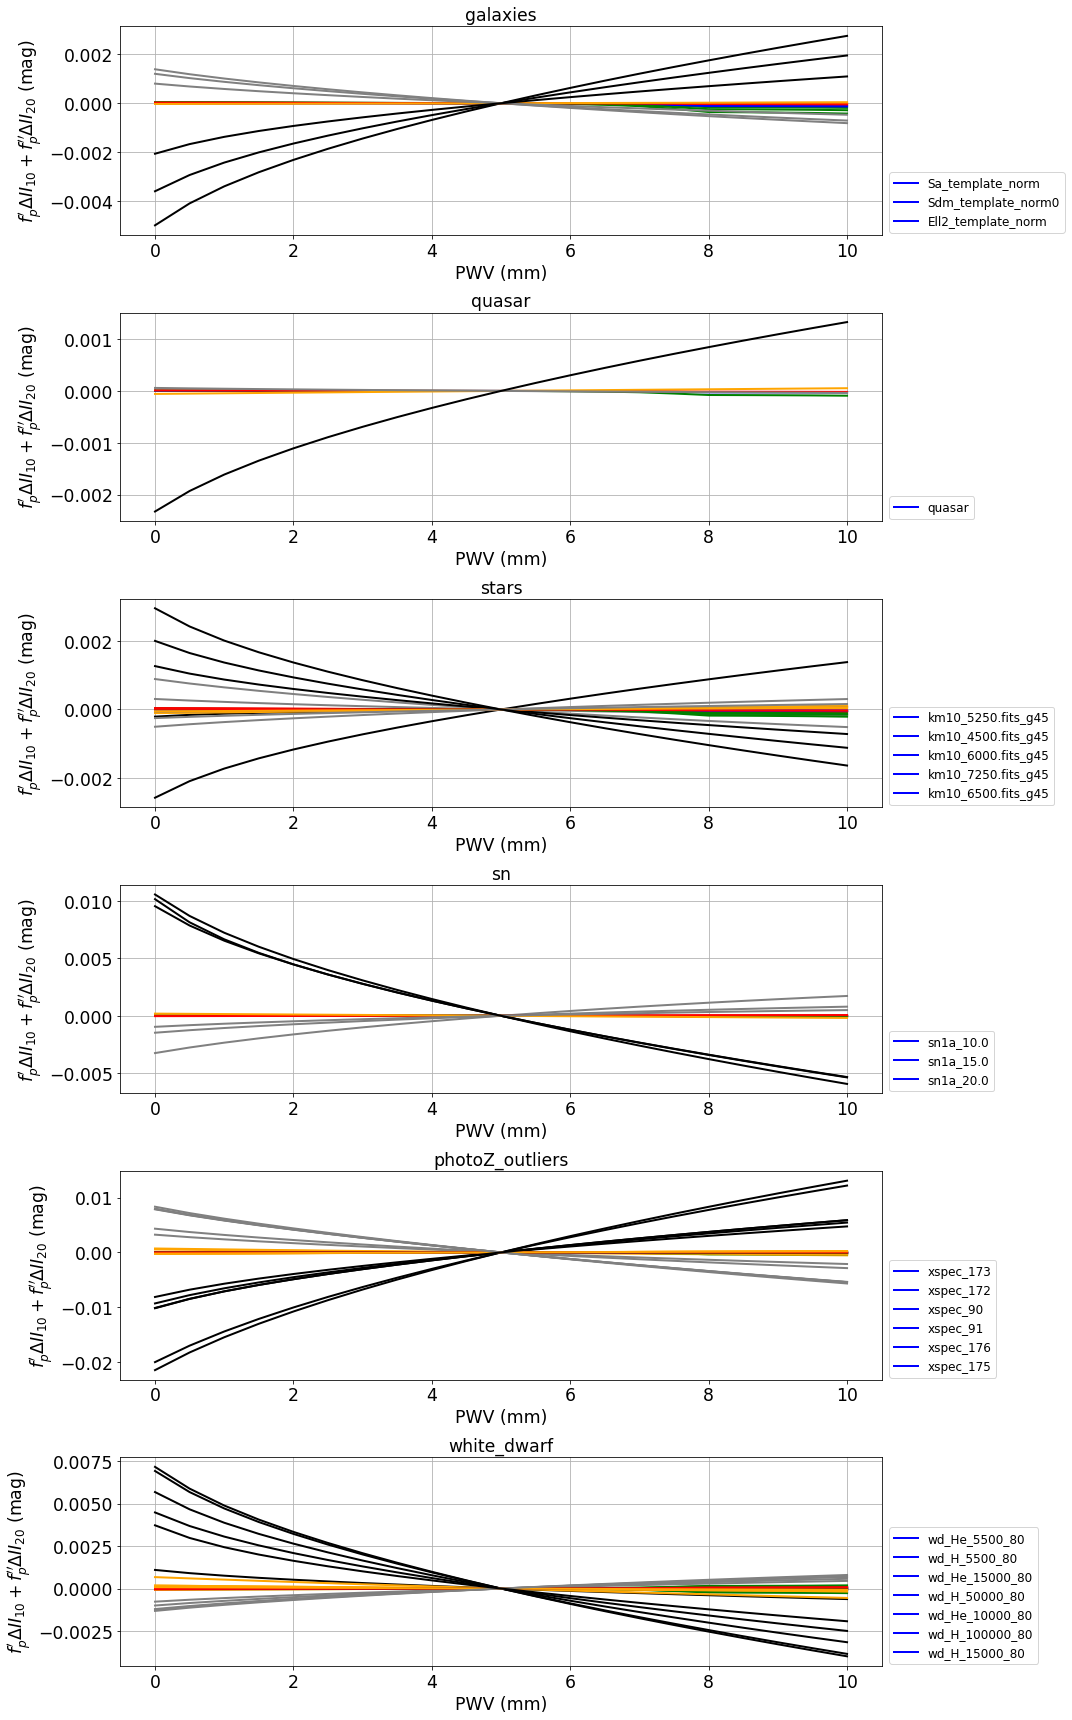

In [98]:
fig, axs = plt.subplots(NSEDTYPES,1,figsize=(15,NSEDTYPES*4))
K=1.087


old_type = None
idx_sed = -1
idx_type = -1

# loop on SED
for index_name, row in df_SED_infos.iterrows():
    idx_sed += 1
    the_type = row["type"]
    if the_type != old_type:
        idx_type+=1
        old_type = the_type
        #print(f"new type {the_type} !!!")
        
    #print("\t",index_name,row["type"])
    for ifilt in range(NFILT):
        
        list_to_pandas = [index_name, the_type, filter_tagnames[ifilt]]
        
        coeff_tag1 = "fp_"+ filter_tagnames[ifilt]
        coeff_value1 = df_SED_infos.loc[index_name][coeff_tag1]
        coeff_tag2 = "fpp_"+ filter_tagnames[ifilt]
        coeff_value2 = df_SED_infos.loc[index_name][coeff_tag2]
        
        
        # init before loop on pwv
        DeltaMag = np.zeros(NPWV)
        # container for mags corrections
        list_data_values = []
        
        # loop on airmass to fill DeltaMag[idx_am] and data_to_pandas
        
        for idx_pwv,pwv in enumerate(all_pwv):
            # get integral difference between observed and standard
            Delta_II10 = all_II_diff[idx_pwv].loc[ifilt]["II10"]
            Delta_II20 = all_II_diff[idx_pwv].loc[ifilt]["II20"]
            
            c1 = K*Delta_II10*coeff_value1
            c2 = K*Delta_II20*coeff_value2
            c3 = -K/2*(Delta_II10*coeff_value1)**2
            c4 = c1+c2+c3
            
    
            # fill container for mag correction
            list_data_values.append(c1)
            list_data_values.append(c2)
            list_data_values.append(c3)
            list_data_values.append(c4)
            
            # array for plotting     
            DeltaMag[idx_pwv] = c4
 

        # make the list
        list_to_pandas = list_to_pandas +  list_data_values
                              
        # add the row to pandas dataframe
        df_pc_col_pwv.loc[idx_sed*6+ifilt] = list_to_pandas
              
              
        # plot for this airmass  for this SED  
        if ifilt==0:
            axs[idx_type].plot(all_pwv,DeltaMag,color=filter_color[ifilt],label=index_name,lw=2) 
        else:
            axs[idx_type].plot(all_pwv,DeltaMag,color=filter_color[ifilt],lw=2)
            
        
        
    
    axs[idx_type].legend(loc=(1.01, 0.01))
    axs[idx_type].set_xlabel("PWV (mm)")
    axs[idx_type].set_ylabel("$f^\prime_p \Delta II_{10}+ f^{\prime\prime}_p \Delta II_{20} $ (mag)")
    axs[idx_type].set_title(the_type)
    axs[idx_type].grid()
            
plt.tight_layout()        
        

In [99]:
df_pc_col_pwv

name         type filter  c_1_pwv_0     c_2_pwv_0  \
0    Sa_template_norm     galaxies      u   0.000003  5.283758e-07   
1    Sa_template_norm     galaxies      g   0.000046  1.029440e-06   
2    Sa_template_norm     galaxies      r   0.000038 -3.557349e-06   
3    Sa_template_norm     galaxies      i  -0.000127  1.522264e-04   
4    Sa_template_norm     galaxies      z   0.001399 -6.636810e-06   
..                ...          ...    ...        ...           ...   
145     wd_H_15000_80  white_dwarf      g   0.000002 -4.880854e-07   
146     wd_H_15000_80  white_dwarf      r  -0.000031  4.096190e-06   
147     wd_H_15000_80  white_dwarf      i   0.000092 -1.157331e-05   
148     wd_H_15000_80  white_dwarf      z  -0.001076 -2.413737e-04   
149     wd_H_15000_80  white_dwarf      y   0.006050 -2.312919e-03   

        c_3_pwv_0  c_t_pwv_0  c_1_pwv_5     c_2_pwv_5     c_3_pwv_5  ...  \
0   -3.163849e-12   0.000003   0.000002  4.873508e-07 -2.735782e-12  ...   
1   -9.692813e-10   0.000047   0.000042  9.321968e-07 -7.959775e-10  ...   
2   -6.630628e-10   0.000034   0.000034 -3.166045e-06 -5.320144e-10  ...   
3   -7.383639e-09   0.000026  -0.000114  1.350691e-04 -6.020317e-09  ...   
4   -9.008303e-07   0.001392   0.001195 -5.713425e-06 -6.570284e-07  ...   
..            ...        ...        ...           ...           ...  ...   
145 -2.682677e-12   0.000002   0.000002 -4.419798e-07 -2.203025e-12  ...   
146 -4.467052e-10  -0.000027  -0.000028  3.645614e-06 -3.584178e-10  ...   
147 -3.853053e-09   0.000080   0.000083 -1.026889e-05 -3.141621e-09  ...   
148 -5.322583e-07  -0.001318  -0.000919 -2.077912e-04 -3.882072e-07  ...   
149 -1.683460e-05   0.003720   0.004975 -1.987140e-03 -1.138460e-05  ...   

       c_3_pwv_90  c_t_pwv_90  c_1_pwv_95  c_2_pwv_95    c_3_pwv_95  \
0   -6.568746e-09   -0.000123   -0.000124   -0.000004 -7.016823e-09   
1   -6.448584e-08   -0.000382   -0.000390   -0.000008 -6.985955e-08   
2   -1.830031e-09   -0.000060   -0.000067    0.000003 -2.085848e-09   
3   -5.053011e-09    0.000006    0.000119   -0.000110 -6.462785e-09   
4   -2.132502e-07   -0.000677   -0.000752    0.000004 -2.598023e-07   
..            ...         ...         ...         ...           ...   
145 -1.784773e-10   -0.000016   -0.000021    0.000004 -1.933501e-10   
146 -1.232891e-09    0.000049    0.000055   -0.000003 -1.405235e-09   
147 -2.636846e-09   -0.000068   -0.000086    0.000008 -3.372517e-09   
148 -1.259995e-07    0.000660    0.000578    0.000152 -1.535050e-07   
149 -3.537556e-06   -0.001584   -0.003076    0.001323 -4.351701e-06   

     c_t_pwv_95  c_1_pwv_100  c_2_pwv_100   c_3_pwv_100  c_t_pwv_100  
0     -0.000127    -0.000131    -0.000004 -7.894612e-09    -0.000135  
1     -0.000397    -0.000415    -0.000008 -7.924597e-08    -0.000423  
2     -0.000064    -0.000073     0.000003 -2.430652e-09    -0.000070  
3      0.000009     0.000132    -0.000121 -8.042174e-09     0.000011  
4     -0.000748    -0.000820     0.000005 -3.091071e-07    -0.000815  
..          ...          ...          ...           ...          ...  
145   -0.000017    -0.000022     0.000004 -2.193288e-10    -0.000018  
146    0.000052     0.000060    -0.000004 -1.637529e-09     0.000056  
147   -0.000077    -0.000096     0.000009 -4.196700e-09    -0.000086  
148    0.000730     0.000630     0.000167 -1.826369e-07     0.000797  
149   -0.001757    -0.003371     0.001450 -5.227251e-06    -0.001926  

[150 rows x 87 columns]

## Error on SED approximation

### Error on Color Photometric Correction bias due to SED approximation
$$
\begin{eqnarray}
\Delta m & = & \left| 2.5 \log_{10}\left(
\frac{\mathbb{I}_0^{std}(b)}
{\mathbb{I}_0^{obs}(b)}\right) +
2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times S_b^{obs}(\lambda) \frac{d\lambda}{\lambda} }{\int_0^\infty F_\nu(\lambda) \times S_b^{std}(\lambda) \frac{d\lambda}{\lambda}} 
	\right) \right. \nonumber \\
    & & \left. - 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)\right|
\end{eqnarray}  
$$

$$
\begin{eqnarray}
\Delta m & = & \left| 
2.5 \log_{10} 
	\left( 
	\frac{\int_0^\infty F_\nu(\lambda) \times \phi_b^{obs}(\lambda) d\lambda}{\int_0^\infty F_\nu(\lambda) \times \phi_b^{std}(\lambda)d\lambda} 
	\right) \right. \nonumber \\
    & & \left. - 1.087\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) +
          \frac{f_\nu^{\prime\prime}(\lambda_b)}{2}\Delta \mathbb{I}_{20}(b) \right. 
         - \left. \frac{1}{2}\left( f_\nu^\prime(\lambda_b) \Delta \mathbb{I}_{10}(b) \right)^2             
          \right)\right|
\end{eqnarray}  
$$

In [100]:
all_columns = OrderedDict()
all_columns["name"] = 'str'
all_columns["type"] = 'str'
all_columns["filter"] = 'str'
for tag in all_pwv_tags:
    all_columns[f"ct_{tag}"] = 'float'
print(all_columns)
print(len(all_columns))

OrderedDict([('name', 'str'), ('type', 'str'), ('filter', 'str'), ('ct_pwv_0', 'float'), ('ct_pwv_5', 'float'), ('ct_pwv_10', 'float'), ('ct_pwv_15', 'float'), ('ct_pwv_20', 'float'), ('ct_pwv_25', 'float'), ('ct_pwv_30', 'float'), ('ct_pwv_35', 'float'), ('ct_pwv_40', 'float'), ('ct_pwv_45', 'float'), ('ct_pwv_50', 'float'), ('ct_pwv_55', 'float'), ('ct_pwv_60', 'float'), ('ct_pwv_65', 'float'), ('ct_pwv_70', 'float'), ('ct_pwv_75', 'float'), ('ct_pwv_80', 'float'), ('ct_pwv_85', 'float'), ('ct_pwv_90', 'float'), ('ct_pwv_95', 'float'), ('ct_pwv_100', 'float')])
24


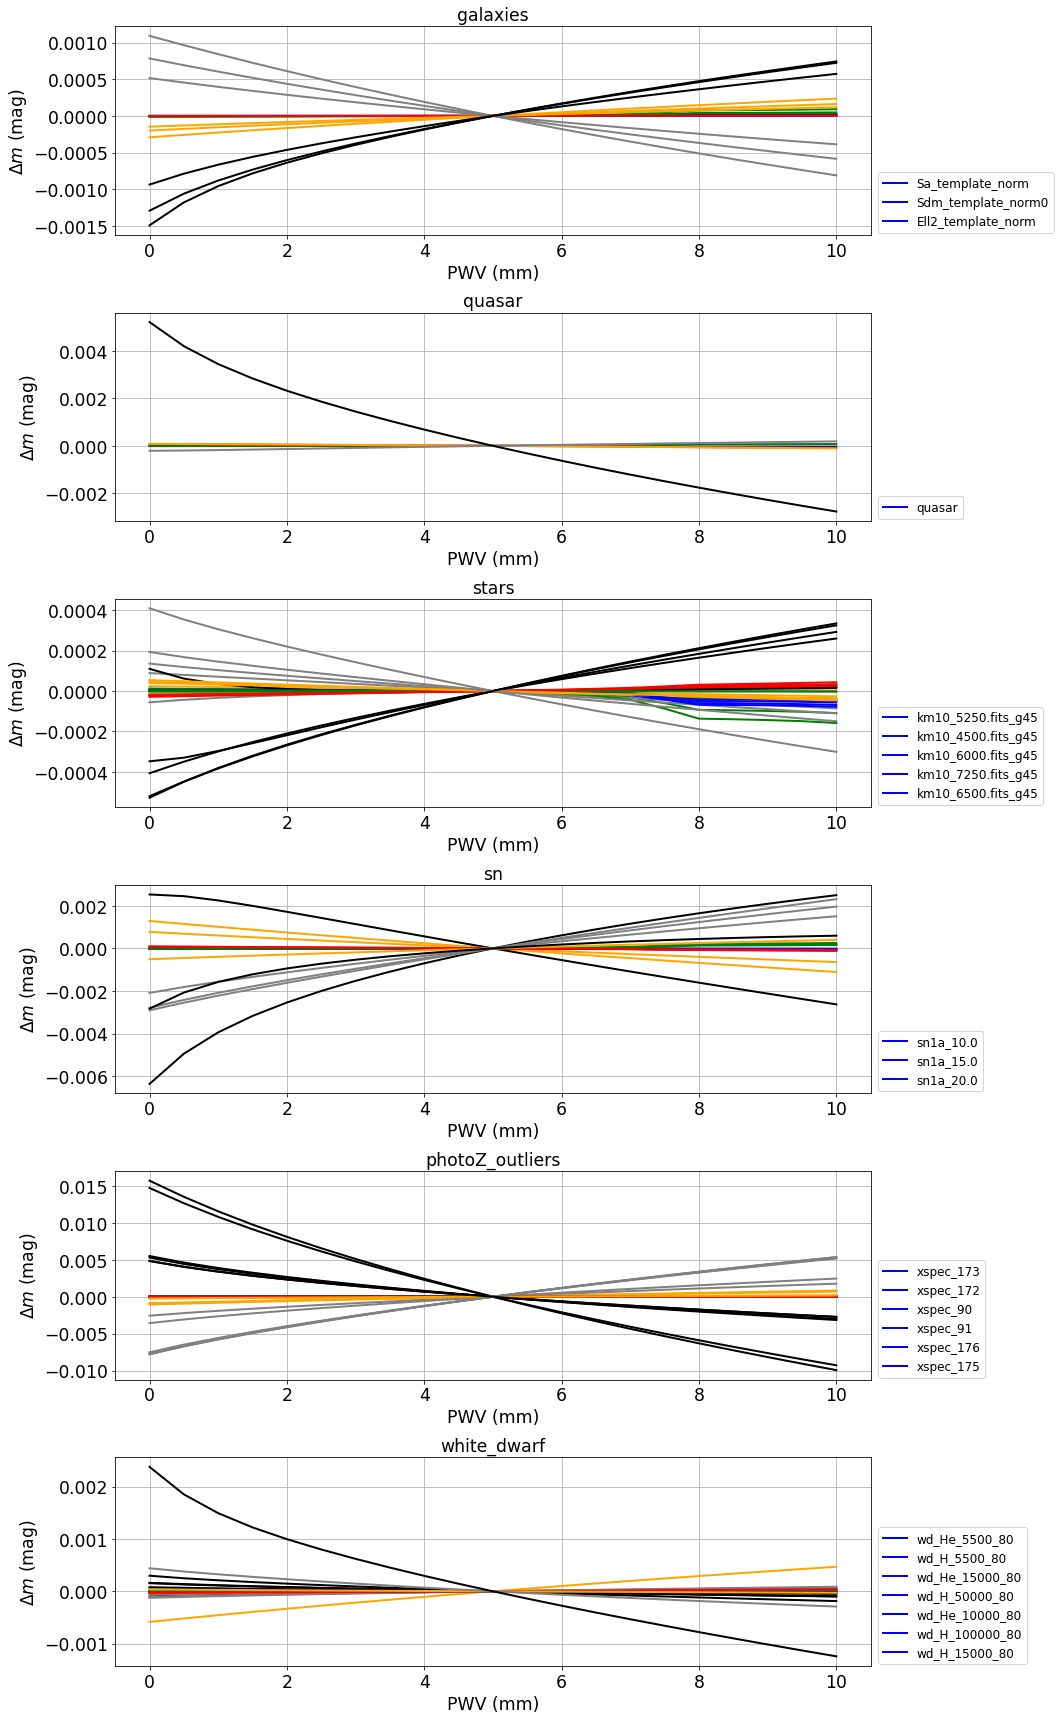

In [101]:
df_pc_col_bias_pwv = pd.DataFrame(columns=all_columns)

fig, axs = plt.subplots(NSEDTYPES,1,figsize=(15,NSEDTYPES*4))
K=1.087

old_type = None
idx_sed = -1


# loop on SED types
for idx_type,sed_type in enumerate(sedtypes):
    
    sednamelist = sedtypeslists[sed_type] 
    NSEDs = len(sednamelist)
    
    
    # loop on objects in sedtypes
    for idx0,sed_name in  enumerate(sednamelist):
        
        idx_sed+=1 
        
        wavel,fnu = seds[sed_name].getSED_fnu()
        
        # loop on filters
        for ifilt in range(NFILT):
            
            list_to_pandas = [sed_name, sed_type, filter_tagnames[ifilt]]
            
            coeff_tag1 = "fp_"+ filter_tagnames[ifilt]
            coeff_value1 = df_SED_infos.loc[sed_name][coeff_tag1]
            coeff_tag2 = "fpp_"+ filter_tagnames[ifilt]
            coeff_value2 = df_SED_infos.loc[sed_name][coeff_tag2]
            
            # init before loop on airlass
            DeltaMag = np.zeros(NPWV)
            # container for mags corrections
            list_data_values = []
            
            #print(list_to_pandas)
            
            # loop on pwv
            for idx_pwv,pwv in enumerate(all_pwv):
                #print(all_df_obs[idx_am].head())
                # get integral difference between observed and standard
                
                #approximation
                Delta_II10 = all_II_diff[idx_pwv].loc[ifilt]["II10"]
                Delta_II20 = all_II_diff[idx_pwv].loc[ifilt]["II20"]
            
                c1 = K*Delta_II10*coeff_value1
                c2 = K*Delta_II20*coeff_value2
                c3 = -K/2*(Delta_II10*coeff_value1)**2
                c4 = c1+c2+c3
                
                # compute the true integral
                the_df_obs=all_df_obs[idx_pwv]
                result_integ1 = ComputeAverage(wavel,fnu,the_df_obs)
                result_integ2 = ComputeAverage(wavel,fnu,df_std)
                
                dm=2.5*np.log10(result_integ1[ifilt]/result_integ2[ifilt]) - c4
                
                list_data_values.append(dm)
                DeltaMag[idx_pwv] = dm
            
            
            # make the list
            list_to_pandas = list_to_pandas +  list_data_values
            
            # add the row to pandas dataframe
            df_pc_col_bias_pwv.loc[idx_sed*6+ifilt] = list_to_pandas
            
            # plot for this airmass  for this SED  
            if ifilt==0:
                axs[idx_type].plot(all_pwv,DeltaMag,color=filter_color[ifilt],label=sed_name,lw=2) 
            else:
                axs[idx_type].plot(all_pwv,DeltaMag,color=filter_color[ifilt],lw=2)
            
        
        
    
    axs[idx_type].legend(loc=(1.01, 0.01))
    axs[idx_type].set_xlabel("PWV (mm)")
    axs[idx_type].set_ylabel("$\Delta m$ (mag)")
    axs[idx_type].set_title(sed_type)
    axs[idx_type].grid()
            
plt.tight_layout()                
        

In [102]:
df_pc_col_bias_pwv

name         type filter      ct_pwv_0      ct_pwv_5  \
0    Sa_template_norm     galaxies      u -8.859236e-07 -8.196756e-07   
1    Sa_template_norm     galaxies      g -1.274977e-05 -1.153648e-05   
2    Sa_template_norm     galaxies      r  4.851938e-07  4.276126e-07   
3    Sa_template_norm     galaxies      i -2.916749e-04 -2.587276e-04   
4    Sa_template_norm     galaxies      z  1.090663e-03  9.638915e-04   
..                ...          ...    ...           ...           ...   
145     wd_H_15000_80  white_dwarf      g -1.746253e-07 -1.740653e-07   
146     wd_H_15000_80  white_dwarf      r -3.252638e-05 -2.922418e-05   
147     wd_H_15000_80  white_dwarf      i  3.447474e-05  3.062657e-05   
148     wd_H_15000_80  white_dwarf      z  4.403004e-04  3.785252e-04   
149     wd_H_15000_80  white_dwarf      y  2.378622e-03  1.852598e-03   

        ct_pwv_10     ct_pwv_15     ct_pwv_20     ct_pwv_25     ct_pwv_30  \
0   -7.610939e-07 -6.945680e-07 -6.102210e-07 -5.289293e-07 -4.463141e-07   
1   -1.031510e-05 -9.083249e-06 -7.838727e-06 -6.583852e-06 -5.313301e-06   
2    3.721965e-07  3.188288e-07  2.671719e-07  2.174200e-07  1.696659e-07   
3   -2.267855e-04 -1.957787e-04 -1.656417e-04 -1.363128e-04 -1.077372e-04   
4    8.417268e-04  7.238665e-04  6.100438e-04  5.000220e-04  3.935885e-04   
..            ...           ...           ...           ...           ...   
145 -1.730451e-07 -1.665498e-07 -1.579802e-07 -1.466812e-07 -1.291834e-07   
146 -2.593515e-05 -2.265681e-05 -1.939002e-05 -1.613412e-05 -1.288806e-05   
147  2.688094e-05  2.323227e-05  1.967533e-05  1.620508e-05  1.281685e-05   
148  3.248846e-04  2.761946e-04  2.308597e-04  1.880400e-04  1.472631e-04   
149  1.493708e-03  1.221626e-03  9.968899e-04  7.998717e-04  6.205101e-04   

     ...     ct_pwv_55     ct_pwv_60     ct_pwv_65     ct_pwv_70  ct_pwv_75  \
0    ...  3.148842e-07  1.588409e-06  3.634895e-06  6.977277e-06   0.000014   
1    ...  1.939975e-06  6.972391e-06  1.444647e-05  2.601194e-05   0.000050   
2    ...  4.193215e-09  2.471653e-07  5.456729e-07  9.415634e-07   0.000002   
3    ...  2.550046e-05  5.049789e-05  7.502813e-05  9.912419e-05   0.000123   
4    ... -9.118811e-05 -1.797951e-04 -2.659564e-04 -3.498097e-04  -0.000432   
..   ...           ...           ...           ...           ...        ...   
145  ...  2.160855e-07  1.361437e-06  3.243994e-06  6.360517e-06   0.000013   
146  ...  3.299654e-06  7.169869e-06  1.115862e-05  1.536874e-05   0.000021   
147  ... -3.038641e-06 -6.016126e-06 -8.936544e-06 -1.180174e-05  -0.000015   
148  ... -3.351790e-05 -6.590038e-05 -9.721861e-05 -1.275393e-04  -0.000157   
149  ... -1.396366e-04 -2.748428e-04 -4.061391e-04 -5.339273e-04  -0.000658   

     ct_pwv_80  ct_pwv_85  ct_pwv_90  ct_pwv_95  ct_pwv_100  
0     0.000023   0.000023   0.000024   0.000024    0.000026  
1     0.000077   0.000079   0.000082   0.000085    0.000091  
2     0.000003   0.000003   0.000003   0.000003    0.000003  
3     0.000146   0.000169   0.000192   0.000214    0.000236  
4    -0.000511  -0.000589  -0.000664  -0.000738   -0.000810  
..         ...        ...        ...        ...         ...  
145   0.000021   0.000021   0.000022   0.000022    0.000024  
146   0.000027   0.000030   0.000034   0.000037    0.000041  
147  -0.000017  -0.000020  -0.000023  -0.000025   -0.000028  
148  -0.000185  -0.000213  -0.000240  -0.000266   -0.000291  
149  -0.000780  -0.000899  -0.001016  -0.001130   -0.001243  

[150 rows x 24 columns]